<a href="https://colab.research.google.com/github/leomarzeuski/ChessGamesAnalasys/blob/master/analise_xadrez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Dados de Xadrez com PySpark (Versão Aprimorada)

Este notebook contém uma análise de dados de xadrez utilizando PySpark, seguindo as três etapas do projeto:

1. Construção de um Ambiente de Big Data (Configuração do Spark)
2. Tarefa de Análise de dados (EDA Aprimorada)
3. Tarefa de Previsão (Modelagem e Otimização)

Vamos analisar estatísticas sobre aberturas (incluindo ECO e relação com ELO),
ratings de jogadores, diferenças nas habilidades, influência do controle de tempo
e terminação, e desenvolver modelos de previsão otimizados para determinar a
chance das peças brancas ganharem.

## Parte 1: Construção de um Ambiente de Big Data

Nesta primeira parte, vamos configurar o ambiente Spark para processamento de dados em larga escala e instalar/importar todas as dependências necessárias.
*Nota: A construção do ambiente em si (ex: com Docker) deve ser documentada separadamente, conforme os requisitos do projeto.*

In [ ]:
# Instalação das dependências necessárias (executar apenas uma vez se necessário)
%pip install pyspark pandas numpy matplotlib seaborn kagglehub findspark scikit-learn

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Importando as bibliotecas necessárias
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import kagglehub
import pathlib
import findspark
import time

# Inicializar o Spark
findspark.init()

# Importações do PySpark após inicialização
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, when, avg, stddev, min, max, round, length,
    split, expr, udf, lower, regexp_extract, first,
    rank, size
)
from pyspark.sql.types import *
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
)
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator, MulticlassClassificationEvaluator
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

# Configurando o estilo dos gráficos
plt.style.use('ggplot')
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.figsize']     = (14, 8)
plt.rcParams['axes.labelsize']     = 14
plt.rcParams['axes.titlesize']     = 16
plt.rcParams['xtick.labelsize']    = 12
plt.rcParams['ytick.labelsize']    = 12
plt.rcParams['legend.fontsize']    = 12

# Configurando o Spark Session para uso local
spark = SparkSession.builder \
    .appName("ChessAnalysisLocal") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

sc = spark.sparkContext

print(f"Versão do Spark: {spark.version}")
print(f"Rodando Spark localmente usando a UI em: {sc.uiWebUrl}")
print("Ambiente Spark configurado para execução local!")
print("Número de núcleos disponíveis:", sc.defaultParallelism)
print("Número de partições padrão:", sc.defaultParallelism)


C:\Users\leoma\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Versão do Spark: 3.5.5
Rodando Spark localmente usando a UI em: http://host.docker.internal:4040
Ambiente Spark configurado para execução local!
Número de núcleos disponíveis: 12
Número de partições padrão: 12


In [ ]:
# Fazendo o download do dataset de xadrez usando kagglehub
print("Baixando o dataset do Kaggle...")
DATA_DIR = pathlib.Path(
    kagglehub.dataset_download("arevel/chess-games")
)
print(f"📂 Arquivos em: {DATA_DIR}\n")
print("Conteúdo:")
csv_files = list(DATA_DIR.glob("*.csv"))
for p in DATA_DIR.iterdir():
    print(f"  - {p.name}")

if not csv_files:
    raise FileNotFoundError(f"Nenhum arquivo CSV encontrado no diretório {DATA_DIR}")

chess_file_path = str(csv_files[0])
print(f"\nUsando o arquivo: {chess_file_path}")

Baixando o dataset do Kaggle...
📂 Arquivos em: C:\Users\leoma\.cache\kagglehub\datasets\arevel\chess-games\versions\1

Conteúdo:
  - chess_games.csv

Usando o arquivo: C:\Users\leoma\.cache\kagglehub\datasets\arevel\chess-games\versions\1\chess_games.csv


## Parte 2: Tarefa de Análise de Dados (Aprimorada)

Carregamento, limpeza inicial e Análise Exploratória de Dados (EDA) aprofundada.

In [ ]:
# Carregando os dados com Spark
start_time = time.time()
print("Carregando o dataset no Spark...")
chess_df = spark.read.csv(chess_file_path, header=True, inferSchema=True)

# Cache para otimizar performance em acessos repetidos
chess_df.cache()

# Forçar a contagem para carregar os dados e medir o tempo
n_total_partidas = chess_df.count()
end_time = time.time()
print(f"Dataset carregado em {end_time - start_time:.2f} segundos.")

# Exibindo o esquema e informações básicas
print("\nEsquema do DataFrame:")
chess_df.printSchema()
print(f"\nNúmero total de partidas: {n_total_partidas:,}")
print(f"Número de colunas: {len(chess_df.columns)}")

# Exibindo as primeiras linhas
print("\nPrimeiras linhas do DataFrame:")
chess_df.show(5, truncate=False)

Carregando o dataset no Spark...
Dataset carregado em 21.16 segundos.

Esquema do DataFrame:
root
 |-- Event: string (nullable = true)
 |-- White: string (nullable = true)
 |-- Black: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- UTCDate: string (nullable = true)
 |-- UTCTime: timestamp (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- WhiteRatingDiff: double (nullable = true)
 |-- BlackRatingDiff: double (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- AN: string (nullable = true)


Número total de partidas: 6,256,184
Número de colunas: 15

Primeiras linhas do DataFrame:
+------------------+---------------+----------+------+----------+-------------------+--------+--------+---------------+---------------+---+---------------------------------------------+-----------+------------+

In [ ]:
# Verificando valores nulos
print("\nVerificando valores nulos...")
null_counts = chess_df.select([count(when(col(c).isNull() | (col(c) == '') | col(c).contains('NA') | col(c).contains('None'), c)).alias(c) for c in chess_df.columns])
null_counts_pd = null_counts.toPandas().transpose()
null_counts_pd.columns = ['null_count']
print("Contagem de valores nulos/vazios por coluna:")
print(null_counts_pd[null_counts_pd['null_count'] > 0])

# A coluna AN (movimentos) pode ter valores nulos ou vazios se a partida for muito curta ou anormal.
# As colunas de RatingDiff também podem ter nulos.
# Vamos investigar e decidir como tratar.
# Por simplicidade inicial, vamos remover linhas com nulos em colunas chave como ELO e Resultado.

cols_to_check_nulls = ["WhiteElo", "BlackElo", "Result", "ECO", "Opening", "TimeControl", "Termination"]

# Filtrando linhas com valores nulos/inválidos nas colunas essenciais
initial_count = chess_df.count()
chess_df_cleaned = chess_df.na.drop(subset=cols_to_check_nulls)

# Filtrar ELOs não razoáveis (ex: < 400 ou > 3500)
chess_df_cleaned = chess_df_cleaned.filter((col("WhiteElo") >= 400) & (col("WhiteElo") <= 3500) & (col("BlackElo") >= 400) & (col("BlackElo") <= 3500))

cleaned_count = chess_df_cleaned.count()
print(f"\nLinhas removidas por valores nulos/inválidos em colunas essenciais ou ELOs irreais: {initial_count - cleaned_count:,}")
print(f"Número de partidas após limpeza inicial: {cleaned_count:,}")

# Re-cache do dataframe limpo
chess_df_cleaned.cache()
chess_df.unpersist()
chess_df = chess_df_cleaned


Verificando valores nulos...
Contagem de valores nulos/vazios por coluna:
                 null_count
White                  8088
Black                  8059
WhiteRatingDiff        4668
BlackRatingDiff        4668

Linhas removidas por valores nulos/inválidos em colunas essenciais ou ELOs irreais: 0
Número de partidas após limpeza inicial: 6,256,184


### 2.1 Análise de Aberturas (Aprofundada)

Análise das aberturas mais comuns (por nome e ECO), suas taxas de vitória e relação com o ELO dos jogadores.


Analisando Aberturas por Nome...

Top 10 Aberturas Mais Comuns (Nome):
+---------------------------------------------+------+
|Opening                                      |count |
+---------------------------------------------+------+
|Van't Kruijs Opening                         |133112|
|Scandinavian Defense: Mieses-Kotroc Variation|112227|
|Modern Defense                               |108120|
|Horwitz Defense                              |95450 |
|Sicilian Defense                             |85645 |
|French Defense: Knight Variation             |83519 |
|Caro-Kann Defense                            |82408 |
|Scandinavian Defense                         |78494 |
|Owen Defense                                 |73452 |
|Sicilian Defense: Bowdler Attack             |72457 |
+---------------------------------------------+------+
only showing top 10 rows



C:\Users\leoma\AppData\Local\Temp\ipykernel_19476\1521135826.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="count", y=opening_col, data=top_openings_pd, palette="viridis")


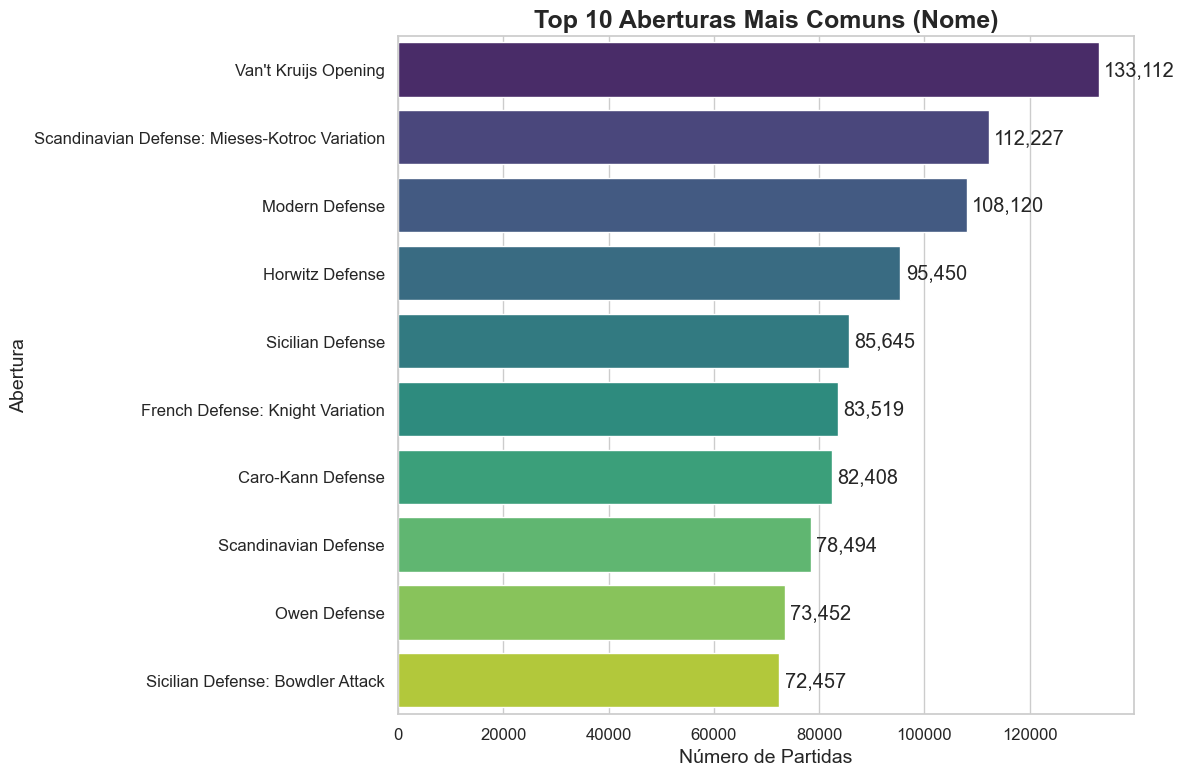

In [ ]:
# Análise das aberturas mais comuns (por nome)
print("\nAnalisando Aberturas por Nome...")
opening_col = 'Opening'
if opening_col in chess_df.columns:
    top_openings = chess_df.groupBy(opening_col).count().orderBy(col("count").desc())
    print("\nTop 10 Aberturas Mais Comuns (Nome):")
    top_openings.show(10, truncate=False)

    # Visualização das Top 10 Aberturas
    top_openings_pd = top_openings.limit(10).toPandas()
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x="count", y=opening_col, data=top_openings_pd, palette="viridis")
    for i, v in enumerate(top_openings_pd["count"]):
        ax.text(v + 1000, i, f"{v:,}", va='center')
    plt.title("Top 10 Aberturas Mais Comuns (Nome)", fontsize=18, fontweight='bold')
    plt.xlabel("Número de Partidas", fontsize=14)
    plt.ylabel("Abertura", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"Coluna '{opening_col}' não encontrada.")


Analisando Aberturas por ECO...

Top 10 Aberturas Mais Comuns (ECO):
+---+------+
|ECO|count |
+---+------+
|A00|423144|
|A40|290613|
|C00|289673|
|B01|286686|
|D00|229168|
|B00|212025|
|C41|195447|
|C20|178498|
|B20|150126|
|D02|128853|
+---+------+
only showing top 10 rows



C:\Users\leoma\AppData\Local\Temp\ipykernel_19476\990218890.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="count", y=eco_col, data=top_ecos_pd, palette="magma")


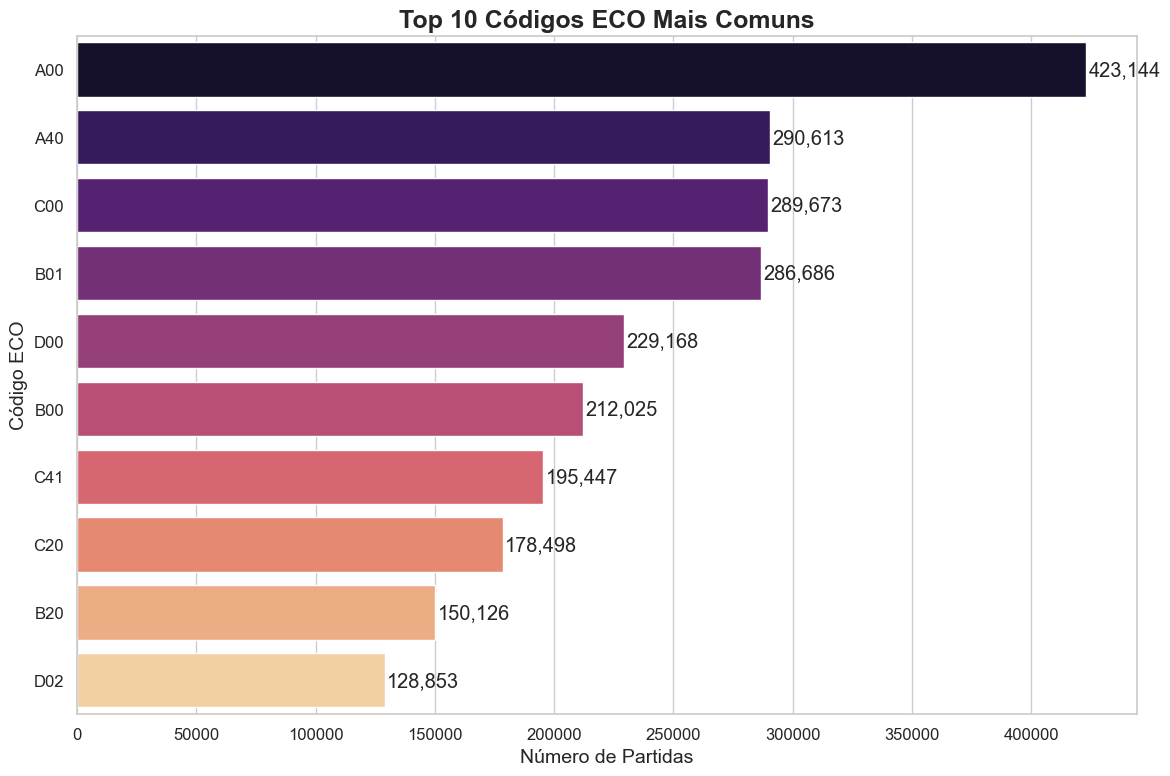

In [ ]:
# Análise das aberturas mais comuns (por ECO - Encyclopedia of Chess Openings)
print("\nAnalisando Aberturas por ECO...")
eco_col = 'ECO'
if eco_col in chess_df.columns:
    top_ecos = chess_df.groupBy(eco_col).count().orderBy(col("count").desc())
    print("\nTop 10 Aberturas Mais Comuns (ECO):")
    top_ecos.show(10, truncate=False)

    # Visualização das Top 10 ECOs
    top_ecos_pd = top_ecos.limit(10).toPandas()
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x="count", y=eco_col, data=top_ecos_pd, palette="magma")
    for i, v in enumerate(top_ecos_pd["count"]):
        ax.text(v + 1000, i, f"{v:,}", va='center')
    plt.title("Top 10 Códigos ECO Mais Comuns", fontsize=18, fontweight='bold')
    plt.xlabel("Número de Partidas", fontsize=14)
    plt.ylabel("Código ECO", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"Coluna '{eco_col}' não encontrada.")


Analisando Taxa de Vitória por Abertura...

Top 10 Aberturas (Nome) por Taxa de Vitória das Brancas (min 1000 jogos):
+-----------------------------------------------------+------------------+-------------------+--------------------+-----------+
|Opening                                              |white_win_rate    |black_win_rate     |draw_rate           |total_games|
+-----------------------------------------------------+------------------+-------------------+--------------------+-----------+
|King's Pawn                                          |0.9259488084730804|0.06919682259488084|0.004766107678729038|11330      |
|Italian Game: Two Knights Defense, Knight Attack     |0.780539397144368 |0.19777895293495504|0.02168164992067689 |1891       |
|Italian Game: Two Knights Defense, Fried Liver Attack|0.7228968867299624|0.2530359902848311 |0.024067122985206447|4529       |
|Russian Game: Damiano Variation                      |0.6744376278118609|0.2952965235173824 |0.03006134969325153

C:\Users\leoma\AppData\Local\Temp\ipykernel_19476\113419329.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="white_win_rate", y=eco_col, data=top_win_ecos_pd, palette="coolwarm")


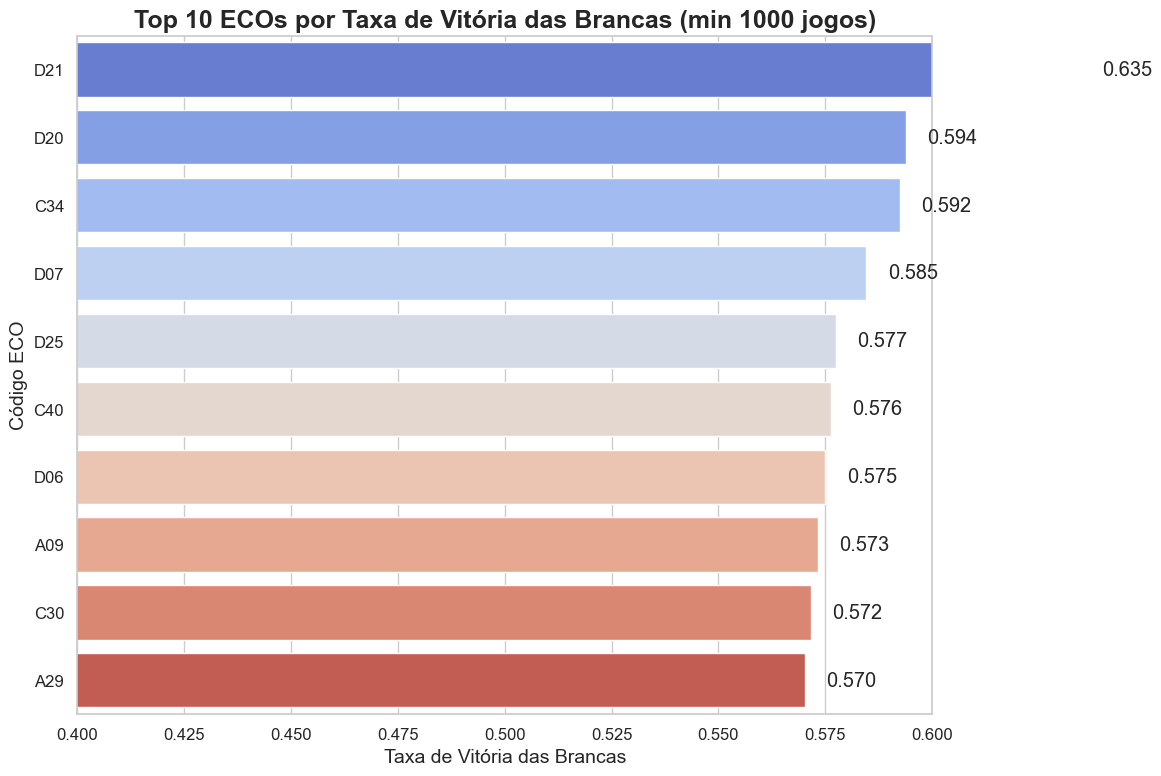

In [ ]:
# Taxa de vitória das brancas por abertura (Nome e ECO)
print("\nAnalisando Taxa de Vitória por Abertura...")
result_col = 'Result'
if opening_col in chess_df.columns and eco_col in chess_df.columns and result_col in chess_df.columns:
    # Criando coluna 'white_wins' (1 se brancas venceram, 0 caso contrário)
    chess_df = chess_df.withColumn("white_wins", when(col(result_col) == "1-0", 1.0).otherwise(0.0))
    chess_df = chess_df.withColumn("black_wins", when(col(result_col) == "0-1", 1.0).otherwise(0.0))
    chess_df = chess_df.withColumn("draw", when(col(result_col) == "1/2-1/2", 1.0).otherwise(0.0))

    # Filtrar aberturas com um número mínimo de jogos para relevância estatística
    min_games_threshold = 1000

    # Por Nome
    opening_win_rates = chess_df.groupBy(opening_col) \
                              .agg(avg("white_wins").alias("white_win_rate"),
                                   avg("black_wins").alias("black_win_rate"),
                                   avg("draw").alias("draw_rate"),
                                   count("*").alias("total_games")) \
                              .filter(col("total_games") > min_games_threshold)

    top_win_rate_openings = opening_win_rates.orderBy(col("white_win_rate").desc())
    print(f"\nTop 10 Aberturas (Nome) por Taxa de Vitória das Brancas (min {min_games_threshold} jogos):")
    top_win_rate_openings.show(10, truncate=False)

    # Por ECO
    eco_win_rates = chess_df.groupBy(eco_col) \
                          .agg(avg("white_wins").alias("white_win_rate"),
                               avg("black_wins").alias("black_win_rate"),
                               avg("draw").alias("draw_rate"),
                               count("*").alias("total_games")) \
                          .filter(col("total_games") > min_games_threshold)

    top_win_rate_ecos = eco_win_rates.orderBy(col("white_win_rate").desc())
    print(f"\nTop 10 Aberturas (ECO) por Taxa de Vitória das Brancas (min {min_games_threshold} jogos):")
    top_win_rate_ecos.show(10, truncate=False)

    # Visualização (Exemplo para ECO)
    top_win_ecos_pd = top_win_rate_ecos.limit(10).toPandas()
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x="white_win_rate", y=eco_col, data=top_win_ecos_pd, palette="coolwarm")
    for i, v in enumerate(top_win_ecos_pd["white_win_rate"]):
        ax.text(v + 0.005, i, f"{v:.3f}", va='center')
    plt.title(f"Top 10 ECOs por Taxa de Vitória das Brancas (min {min_games_threshold} jogos)", fontsize=18, fontweight='bold')
    plt.xlabel("Taxa de Vitória das Brancas", fontsize=14)
    plt.ylabel("Código ECO", fontsize=14)
    plt.xlim(0.4, 0.6) # Ajustar limites se necessário
    plt.tight_layout()
    plt.show()
else:
    print("Colunas 'Opening', 'ECO' ou 'Result' não encontradas.")

In [ ]:
# Análise de Aberturas (ECO) por Faixa de ELO
print("\nAnalisando Aberturas (ECO) por Faixa de ELO...")
if eco_col in chess_df.columns and 'WhiteElo' in chess_df.columns and 'BlackElo' in chess_df.columns:
    # Criar faixa de ELO médio
    chess_df = chess_df.withColumn("avg_elo", (col("WhiteElo") + col("BlackElo")) / 2)
    chess_df = chess_df.withColumn("elo_range",
                                   when(col("avg_elo") < 1200, "<1200")
                                   .when((col("avg_elo") >= 1200) & (col("avg_elo") < 1600), "1200-1599")
                                   .when((col("avg_elo") >= 1600) & (col("avg_elo") < 2000), "1600-1999")
                                   .when((col("avg_elo") >= 2000) & (col("avg_elo") < 2400), "2000-2399")
                                   .otherwise("2400+"))

    # Contar ECOs por faixa de ELO
    eco_by_elo = chess_df.groupBy("elo_range", eco_col).count()

    # Encontrar o ECO mais comum para cada faixa de ELO
    from pyspark.sql.window import Window
    window_spec = Window.partitionBy("elo_range").orderBy(col("count").desc())
    top_eco_by_elo = eco_by_elo.withColumn("rank", rank().over(window_spec)) \
                             .filter(col("rank") <= 5) # Top 5 ECOs por faixa

    print("\nTop 5 ECOs mais comuns por Faixa de ELO Médio:")
    top_eco_by_elo.select("elo_range", eco_col, "count").orderBy("elo_range", col("count").desc()).show(50, truncate=False)

    # Pivoting para visualização (opcional, pode ser pesado)
    # top_eco_by_elo_pivot = top_eco_by_elo.filter(col("rank") == 1) \
    #                                    .groupBy("elo_range").pivot(eco_col).agg(first("count"))
    # print("\nECO mais comum por Faixa de ELO:")
    # top_eco_by_elo_pivot.show(truncate=False)

else:
    print("Colunas 'ECO', 'WhiteElo' ou 'BlackElo' não encontradas.")


Analisando Aberturas (ECO) por Faixa de ELO...

Top 5 ECOs mais comuns por Faixa de ELO Médio:
+---------+---+------+
|elo_range|ECO|count |
+---------+---+------+
|1200-1599|A00|124763|
|1200-1599|C20|101217|
|1200-1599|B01|95154 |
|1200-1599|C00|86401 |
|1200-1599|D00|86115 |
|1600-1999|A00|230608|
|1600-1999|A40|171984|
|1600-1999|C00|171145|
|1600-1999|B01|156860|
|1600-1999|D00|120297|
|2000-2399|A00|58090 |
|2000-2399|A40|38611 |
|2000-2399|B01|29837 |
|2000-2399|C00|28297 |
|2000-2399|A04|26669 |
|2400+    |A00|2890  |
|2400+    |A04|1756  |
|2400+    |A40|1552  |
|2400+    |A45|996   |
|2400+    |B01|915   |
|<1200    |C20|8516  |
|<1200    |A00|6793  |
|<1200    |D00|4347  |
|<1200    |B01|3920  |
|<1200    |C00|3278  |
+---------+---+------+



### 2.2 Análise de Ratings e Diferença de Rating

Análise da distribuição dos ratings e o impacto da diferença de rating no resultado.


Analisando Distribuição de Ratings...


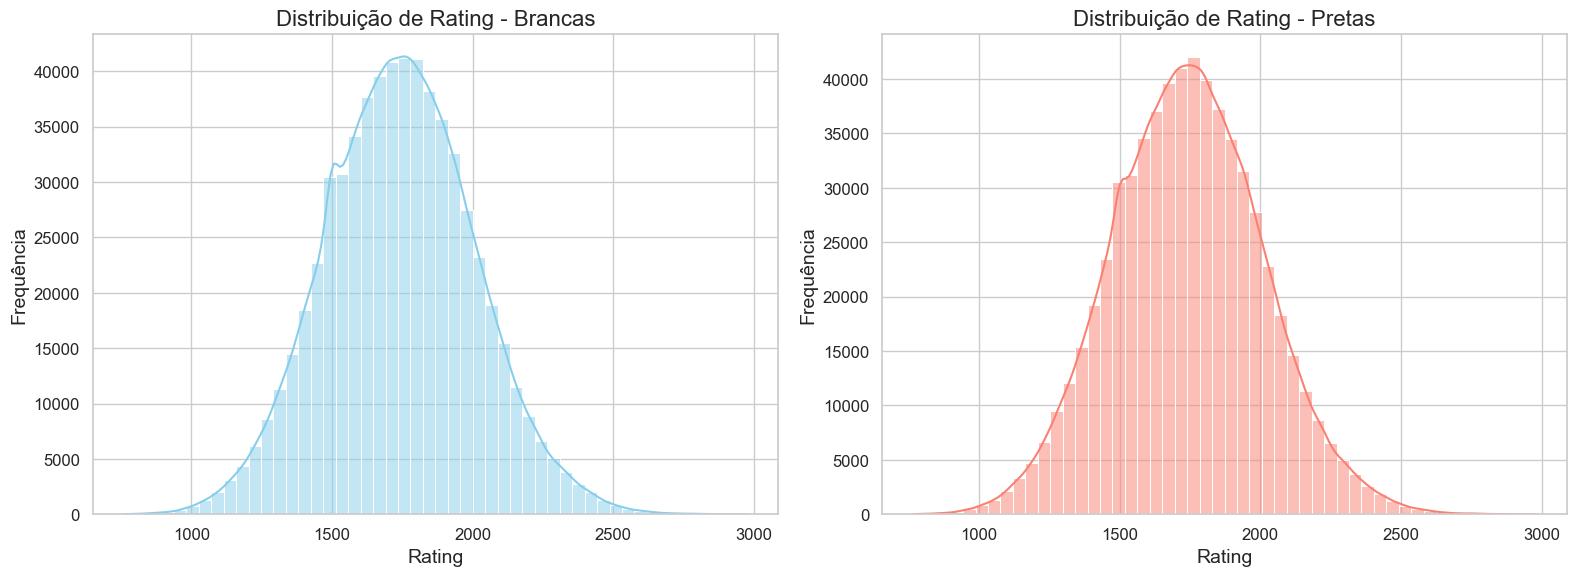

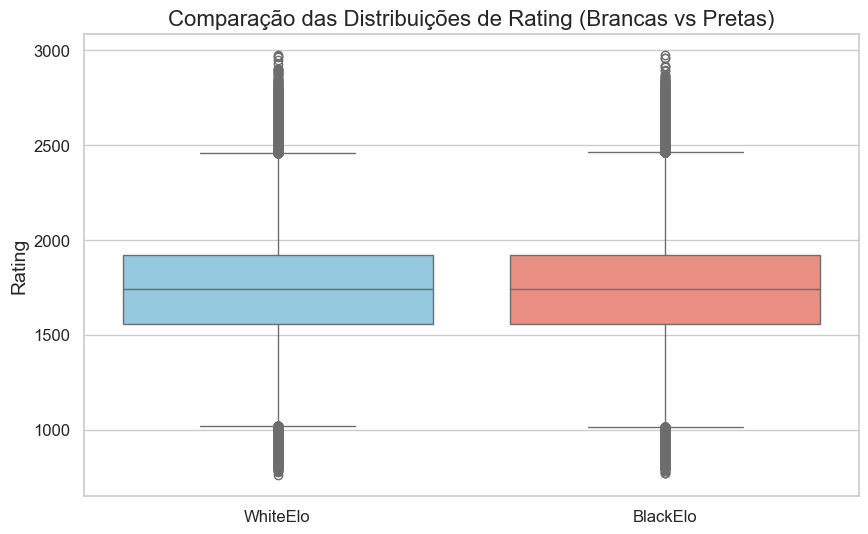


Estatísticas Descritivas dos Ratings:
+------------------+-----------------+-----------+-----------+-----------------+-----------------+----------+----------+
|     Média Brancas|       DP Brancas|Min Brancas|Max Brancas|     Média Pretas|        DP Pretas|Min Pretas|Max Pretas|
+------------------+-----------------+-----------+-----------+-----------------+-----------------+----------+----------+
|1741.9453049974234|265.7170528378767|        737|       3110|1740.390282638746|266.8938055381729|       728|      3108|
+------------------+-----------------+-----------+-----------+-----------------+-----------------+----------+----------+


Coluna 'rating_diff' criada.
+--------+--------+-----------+
|WhiteElo|BlackElo|rating_diff|
+--------+--------+-----------+
|    1901|    1896|          5|
|    1641|    1627|         14|
|    1647|    1688|        -41|
|    1706|    1317|        389|
|    1945|    1900|         45|
+--------+--------+-----------+
only showing top 5 rows



In [ ]:
# Análise de Ratings (já presente no original, mantida e verificada)
print("\nAnalisando Distribuição de Ratings...")
if "WhiteElo" in chess_df.columns and "BlackElo" in chess_df.columns:
    # Convertendo para pandas para visualização (usar sample para datasets grandes)
    sample_fraction = 0.1 # Ajustar conforme necessário para performance
    ratings_pd = chess_df.select("WhiteElo", "BlackElo").sample(withReplacement=False, fraction=sample_fraction, seed=42).toPandas()

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(ratings_pd["WhiteElo"], bins=50, kde=True, color="skyblue")
    plt.title("Distribuição de Rating - Brancas", fontsize=16)
    plt.xlabel("Rating", fontsize=14)
    plt.ylabel("Frequência", fontsize=14)

    plt.subplot(1, 2, 2)
    sns.histplot(ratings_pd["BlackElo"], bins=50, kde=True, color="salmon")
    plt.title("Distribuição de Rating - Pretas", fontsize=16)
    plt.xlabel("Rating", fontsize=14)
    plt.ylabel("Frequência", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Boxplot para comparar distribuições
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=ratings_pd, palette=["skyblue", "salmon"])
    plt.title("Comparação das Distribuições de Rating (Brancas vs Pretas)", fontsize=16)
    plt.ylabel("Rating", fontsize=14)
    plt.show()

    # Estatísticas Descritivas
    print("\nEstatísticas Descritivas dos Ratings:")
    chess_df.select(avg("WhiteElo").alias("Média Brancas"), stddev("WhiteElo").alias("DP Brancas"),
                    min("WhiteElo").alias("Min Brancas"), max("WhiteElo").alias("Max Brancas"),
                    avg("BlackElo").alias("Média Pretas"), stddev("BlackElo").alias("DP Pretas"),
                    min("BlackElo").alias("Min Pretas"), max("BlackElo").alias("Max Pretas")).show()

    # Adicionando coluna de diferença de rating (Brancas - Pretas)
    chess_df = chess_df.withColumn("rating_diff", col("WhiteElo") - col("BlackElo"))
    print("\nColuna 'rating_diff' criada.")
    chess_df.select("WhiteElo", "BlackElo", "rating_diff").show(5)

else:
    print("Colunas 'WhiteElo' ou 'BlackElo' não encontradas.")


Analisando Relação entre Diferença de Rating e Resultado...

Relação entre Diferença de Rating Agrupada e Resultado:
+-----------------+--------------------+------------------+--------------------+-----------+
|rating_diff_group|      white_win_rate|    black_win_rate|           draw_rate|total_games|
+-----------------+--------------------+------------------+--------------------+-----------+
|            -1150|0.020689655172413793|0.9793103448275862|                 0.0|        145|
|            -1100| 0.03755868544600939|0.9577464788732394|0.004694835680751174|        213|
|            -1050|             0.03125|           0.96875|                 0.0|        352|
|            -1000| 0.02654867256637168|0.9699115044247788|0.003539823008849...|        565|
|             -950|0.030821917808219176|0.9646118721461188|  0.0045662100456621|        876|
|             -900|0.029661016949152543|0.9646892655367232|0.005649717514124294|       1416|
|             -850| 0.03203342618384401|0.959

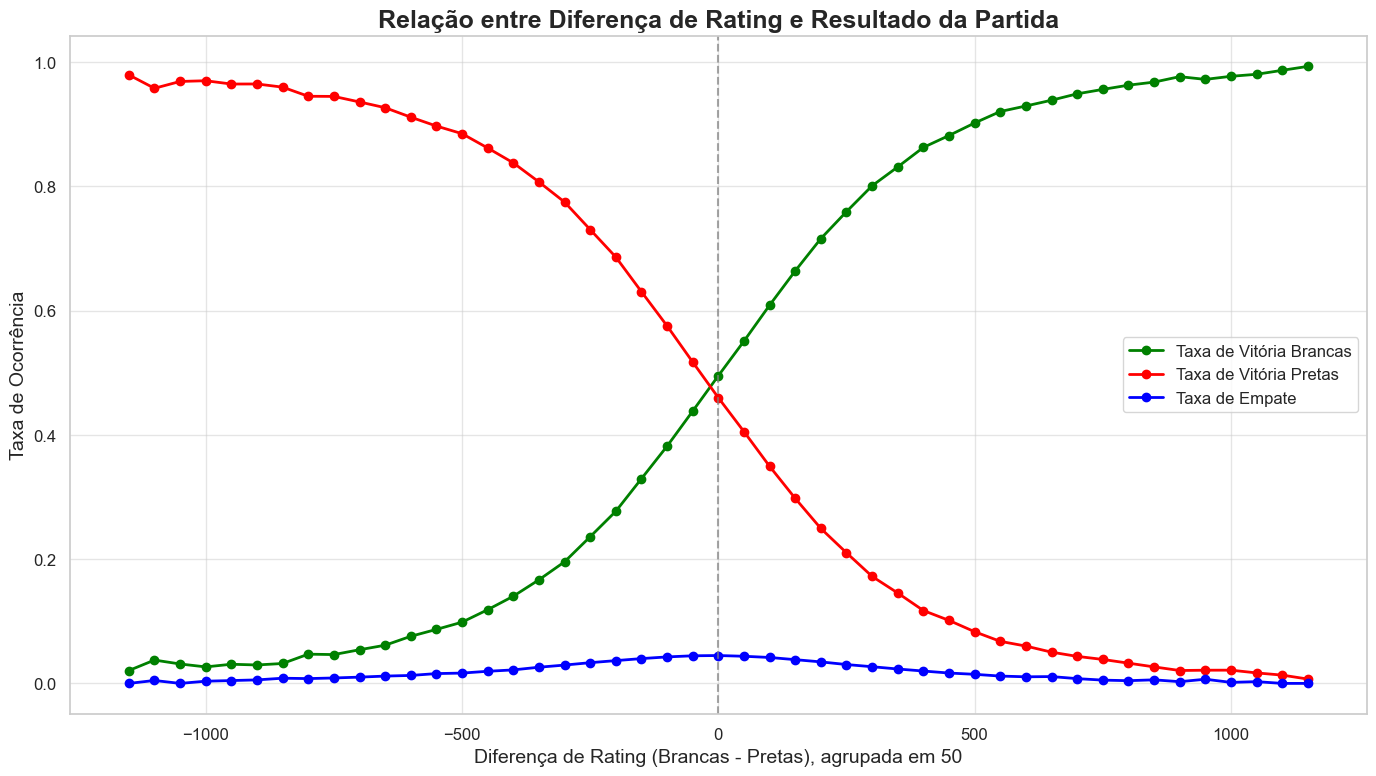

In [ ]:
# Relação entre Diferença de Rating e Resultado (já presente no original, mantida e verificada)
print("\nAnalisando Relação entre Diferença de Rating e Resultado...")
if "rating_diff" in chess_df.columns and "white_wins" in chess_df.columns:
    # Agrupando por diferença de rating (arredondada para intervalos)
    interval = 50
    chess_df = chess_df.withColumn("rating_diff_group", (round(col("rating_diff") / interval) * interval).cast("integer"))

    rating_diff_results = chess_df.groupBy("rating_diff_group") \
                                .agg(avg("white_wins").alias("white_win_rate"),
                                     avg("black_wins").alias("black_win_rate"),
                                     avg("draw").alias("draw_rate"),
                                     count("*").alias("total_games")) \
                                .filter(col("total_games") > 100) \
                                .orderBy("rating_diff_group")

    print("\nRelação entre Diferença de Rating Agrupada e Resultado:")
    rating_diff_results.show(20)

    # Convertendo para pandas para visualização
    rating_diff_pd = rating_diff_results.toPandas()

    # Gráfico de linha
    plt.figure(figsize=(14, 8))
    plt.plot(rating_diff_pd["rating_diff_group"], rating_diff_pd["white_win_rate"], 'o-', color='green', linewidth=2, label='Taxa de Vitória Brancas')
    plt.plot(rating_diff_pd["rating_diff_group"], rating_diff_pd["black_win_rate"], 'o-', color='red', linewidth=2, label='Taxa de Vitória Pretas')
    plt.plot(rating_diff_pd["rating_diff_group"], rating_diff_pd["draw_rate"], 'o-', color='blue', linewidth=2, label='Taxa de Empate')
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
    plt.grid(True, alpha=0.5)
    plt.title("Relação entre Diferença de Rating e Resultado da Partida", fontsize=18, fontweight='bold')
    plt.xlabel(f"Diferença de Rating (Brancas - Pretas), agrupada em {interval}", fontsize=14)
    plt.ylabel("Taxa de Ocorrência", fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Colunas 'rating_diff' ou 'white_wins' não encontradas.")

### 2.3 Análise por Controle de Tempo e Terminação

Explorando como o controle de tempo e a forma como a partida termina influenciam os resultados.

<>:6: SyntaxWarning: invalid escape sequence '\+'
<>:6: SyntaxWarning: invalid escape sequence '\+'
C:\Users\leoma\AppData\Local\Temp\ipykernel_19476\970438047.py:6: SyntaxWarning: invalid escape sequence '\+'
  chess_df = chess_df.withColumn("time_parts", split(col(time_control_col), "\+"))



Analisando por Controle de Tempo...

Distribuição das Categorias de Tempo:
+-------------+-------+
|time_category|  count|
+-------------+-------+
|        Blitz|3101914|
|       Bullet|1744962|
|        Rapid|1314977|
|    Classical|  94331|
+-------------+-------+


Resultado por Categoria de Tempo:
+-------------+-------------------+-------------------+--------------------+-----------+
|time_category|     white_win_rate|     black_win_rate|           draw_rate|total_games|
+-------------+-------------------+-------------------+--------------------+-----------+
|        Blitz|  0.496706227187472| 0.4620260265113733|0.041059165405617305|    3101914|
|       Bullet| 0.4979586948025229|  0.471095072557454|0.030664851154351785|    1744962|
|        Rapid|0.49977299983193624|0.45950841725748814|0.040567249465199774|    1314977|
|    Classical|0.49530907124911216| 0.4552374086991551|0.049389914238161366|      94331|
+-------------+-------------------+-------------------+------------------

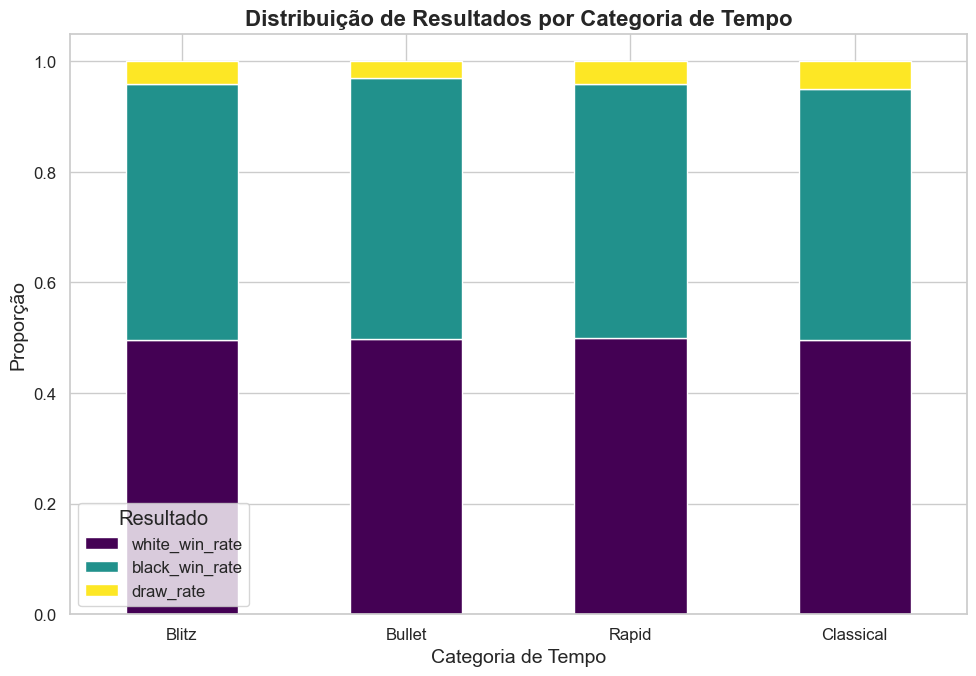

In [ ]:
# Análise por Controle de Tempo
print("\nAnalisando por Controle de Tempo...")
time_control_col = 'TimeControl'
if time_control_col in chess_df.columns and 'white_wins' in chess_df.columns:
    # Extrair tempo base e incremento
    chess_df = chess_df.withColumn("time_parts", split(col(time_control_col), "\+"))
    chess_df = chess_df.withColumn("base_time_seconds", col("time_parts")[0].cast("integer"))
    chess_df = chess_df.withColumn("increment_seconds", col("time_parts")[1].cast("integer"))
    chess_df = chess_df.na.fill({'increment_seconds': 0}) # Preencher nulos no incremento com 0

    # Categorizar controle de tempo (aproximado)
    chess_df = chess_df.withColumn("time_category",
        when(col("base_time_seconds") + 40 * col("increment_seconds") < 180, "Bullet") # < 3 min
        .when(col("base_time_seconds") + 40 * col("increment_seconds") < 600, "Blitz") # < 10 min
        .when(col("base_time_seconds") + 40 * col("increment_seconds") < 1800, "Rapid") # < 30 min
        .otherwise("Classical"))

    print("\nDistribuição das Categorias de Tempo:")
    chess_df.groupBy("time_category").count().orderBy(col("count").desc()).show()

    # Taxa de vitória por categoria de tempo
    time_cat_results = chess_df.groupBy("time_category") \
                               .agg(avg("white_wins").alias("white_win_rate"),
                                    avg("black_wins").alias("black_win_rate"),
                                    avg("draw").alias("draw_rate"),
                                    count("*").alias("total_games")) \
                               .orderBy(col("total_games").desc())

    print("\nResultado por Categoria de Tempo:")
    time_cat_results.show()

    # Visualização
    time_cat_pd = time_cat_results.toPandas().set_index('time_category')
    time_cat_pd[['white_win_rate', 'black_win_rate', 'draw_rate']].plot(kind='bar', stacked=True, figsize=(10, 7), colormap='viridis')
    plt.title("Distribuição de Resultados por Categoria de Tempo", fontsize=16, fontweight='bold')
    plt.xlabel("Categoria de Tempo", fontsize=14)
    plt.ylabel("Proporção", fontsize=14)
    plt.xticks(rotation=0)
    plt.legend(title='Resultado')
    plt.tight_layout()
    plt.show()
else:
    print("Colunas 'TimeControl' ou 'white_wins' não encontradas.")


Analisando por Tipo de Terminação...

Tipos de Terminação Mais Comuns:
+----------------+-------+
|Termination     |count  |
+----------------+-------+
|Normal          |4230089|
|Time forfeit    |2011336|
|Abandoned       |14630  |
|Rules infraction|128    |
|Unterminated    |1      |
+----------------+-------+


Resultado por Tipo de Terminação (min 100 jogos):
+----------------+------------------+--------------------+--------------------+-----------+
|Termination     |white_win_rate    |black_win_rate      |draw_rate           |total_games|
+----------------+------------------+--------------------+--------------------+-----------+
|Normal          |0.500398454973406 |0.45533320930127    |0.04426833572532398 |4230089    |
|Time forfeit    |0.4889451588396966|0.48539229646364407 |0.025662544696659333|2011336    |
|Abandoned       |0.9077922077922078|4.784688995215311E-4|0.0                 |14630      |
|Rules infraction|1.0               |0.0                 |0.0                 |12

C:\Users\leoma\AppData\Local\Temp\ipykernel_19476\2168471432.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="white_win_rate", y=termination_col, data=termination_pd, palette="plasma")


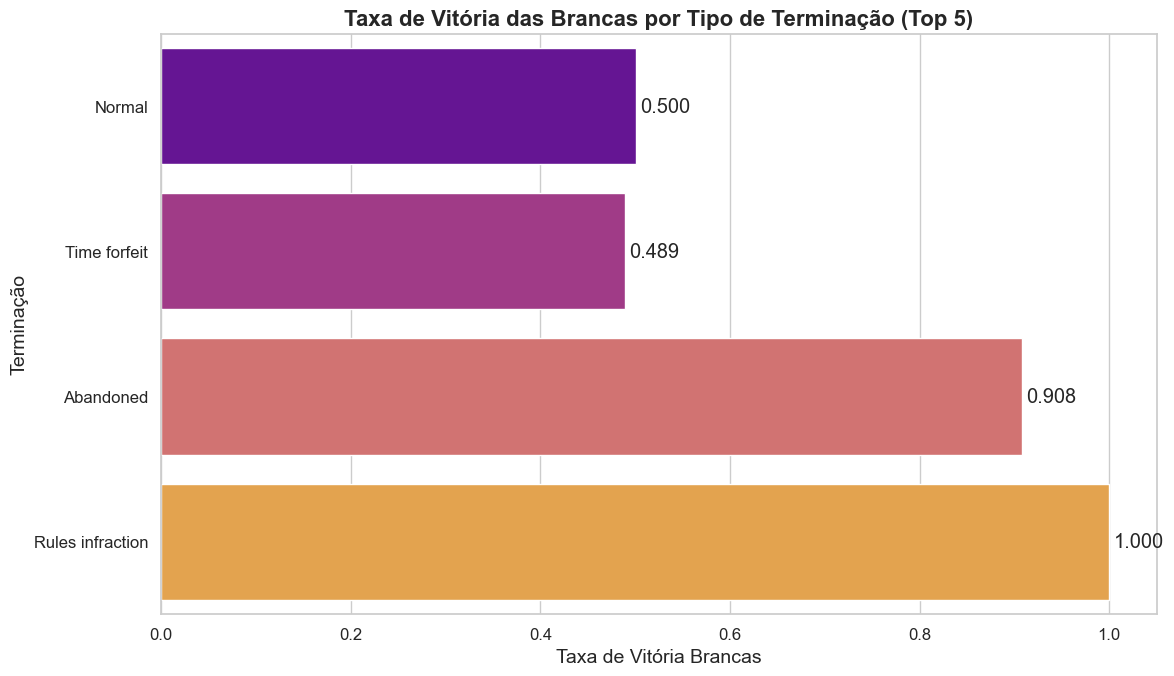

In [ ]:
# Análise por Tipo de Terminação
print("\nAnalisando por Tipo de Terminação...")
termination_col = 'Termination'
if termination_col in chess_df.columns and 'white_wins' in chess_df.columns:
    print("\nTipos de Terminação Mais Comuns:")
    chess_df.groupBy(termination_col).count().orderBy(col("count").desc()).show(truncate=False)

    # Taxa de vitória por tipo de terminação
    termination_results = chess_df.groupBy(termination_col) \
                                  .agg(avg("white_wins").alias("white_win_rate"),
                                       avg("black_wins").alias("black_win_rate"),
                                       avg("draw").alias("draw_rate"),
                                       count("*").alias("total_games")) \
                                  .filter(col("total_games") > 100) \
                                  .orderBy(col("total_games").desc())

    print("\nResultado por Tipo de Terminação (min 100 jogos):")
    termination_results.show(truncate=False)

    # Visualização (Top 5)
    termination_pd = termination_results.limit(5).toPandas()
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x="white_win_rate", y=termination_col, data=termination_pd, palette="plasma")
    for i, v in enumerate(termination_pd["white_win_rate"]):
        ax.text(v + 0.005, i, f"{v:.3f}", va='center')
    plt.title("Taxa de Vitória das Brancas por Tipo de Terminação (Top 5)", fontsize=16, fontweight='bold')
    plt.xlabel("Taxa de Vitória Brancas", fontsize=14)
    plt.ylabel("Terminação", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Colunas 'Termination' ou 'white_wins' não encontradas.")

### 2.4 Análise de Lances (Exploração Inicial da Coluna 'AN')

Extrair informações básicas da coluna 'AN', como número de lances.
*Nota: Análise mais profunda de lances ou avaliações Stockfish requer bibliotecas específicas de xadrez e parsing mais complexo.*


Analisando Número de Lances...

Estatísticas do Número de Lances por Partida:
+-----------------+-----------------+----------+----------+
|     Média Lances|        DP Lances|Min Lances|Max Lances|
+-----------------+-----------------+----------+----------+
|33.88587835651892|15.46898341001797|         1|       290|
+-----------------+-----------------+----------+----------+



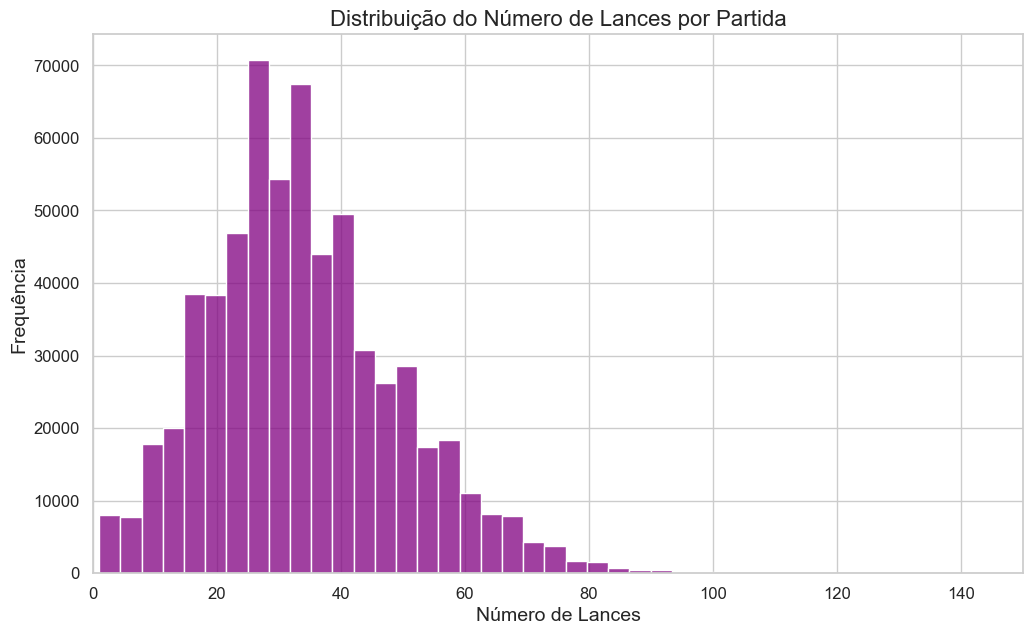

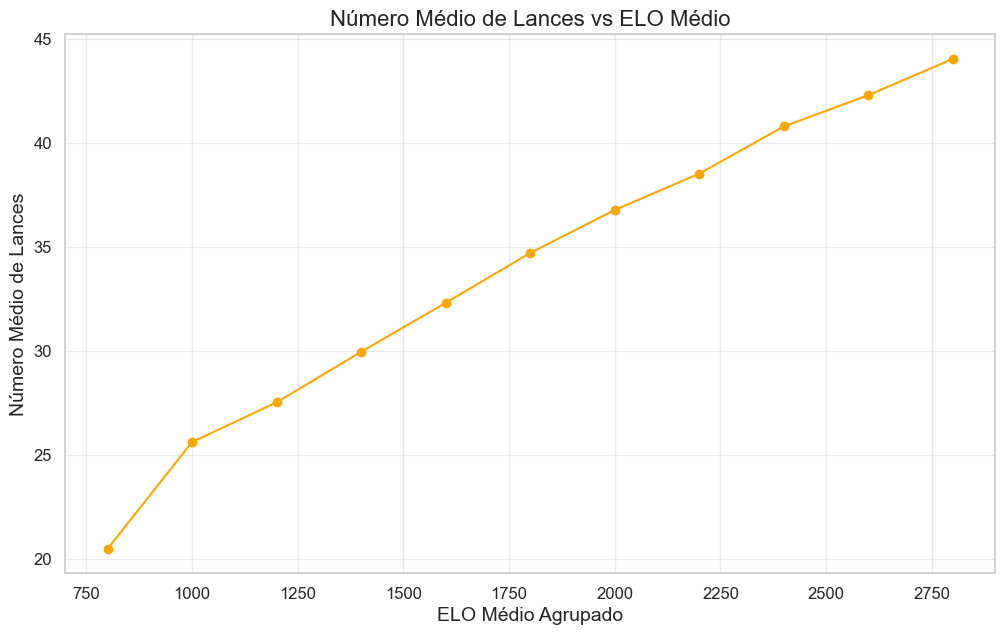

In [ ]:
# Análise do Número de Lances
an_col = 'AN'
if an_col in chess_df.columns:
    print("\nAnalisando Número de Lances...")
    # Contar o número de movimentos (pares de lances brancas/pretas)
    # Um lance completo é "1. e4 e5", então contamos os números seguidos de ponto.
    chess_df = chess_df.withColumn("num_moves", size(split(col(an_col), "\\d+\\. ")) - 1)

    # Lidar com casos onde a regex pode falhar ou partidas muito curtas
    chess_df = chess_df.withColumn("num_moves", when(col("num_moves") < 0, 0).otherwise(col("num_moves")))

    print("\nEstatísticas do Número de Lances por Partida:")
    chess_df.select(avg("num_moves").alias("Média Lances"),
                    stddev("num_moves").alias("DP Lances"),
                    min("num_moves").alias("Min Lances"),
                    max("num_moves").alias("Max Lances")).show()

    # Histograma do número de lances
    moves_pd = chess_df.select("num_moves").sample(0.1).toPandas()
    plt.figure(figsize=(12, 7))
    sns.histplot(moves_pd["num_moves"], bins=50, kde=False, color="purple")
    plt.title("Distribuição do Número de Lances por Partida", fontsize=16)
    plt.xlabel("Número de Lances", fontsize=14)
    plt.ylabel("Frequência", fontsize=14)
    plt.xlim(0, 150) # Limitar eixo X para melhor visualização
    plt.show()

    # Relação entre número de lances e ELO médio
    if "avg_elo" in chess_df.columns:
        chess_df = chess_df.withColumn("avg_elo_group", (round(col("avg_elo") / 200) * 200).cast("integer"))
        moves_vs_elo = chess_df.groupBy("avg_elo_group") \
                               .agg(avg("num_moves").alias("avg_num_moves"),
                                    count("*").alias("total_games")) \
                               .filter(col("total_games") > 100) \
                               .orderBy("avg_elo_group")

        moves_vs_elo_pd = moves_vs_elo.toPandas()
        plt.figure(figsize=(12, 7))
        plt.plot(moves_vs_elo_pd["avg_elo_group"], moves_vs_elo_pd["avg_num_moves"], 'o-', color='orange')
        plt.title("Número Médio de Lances vs ELO Médio", fontsize=16)
        plt.xlabel("ELO Médio Agrupado", fontsize=14)
        plt.ylabel("Número Médio de Lances", fontsize=14)
        plt.grid(True, alpha=0.4)
        plt.show()
else:
    print(f"Coluna '{an_col}' não encontrada.")

## Parte 3: Tarefa de Previsão (Aprimorada)

Preparação dos dados, engenharia de features, treinamento, avaliação detalhada e otimização de modelos para prever a vitória das brancas.

In [ ]:
# Preparando os dados para o modelo
print("\nPreparando dados para modelagem...")

# Selecionando colunas relevantes iniciais
feature_cols_numeric = []
feature_cols_categorical = []

if "WhiteElo" in chess_df.columns and "BlackElo" in chess_df.columns:
    feature_cols_numeric.extend(["WhiteElo", "BlackElo"]) # Ratings individuais
if "rating_diff" in chess_df.columns:
    feature_cols_numeric.append("rating_diff") # Diferença de rating

# Feature: Jogador com maior rating joga de brancas?
if "rating_diff" in chess_df.columns:
    chess_df = chess_df.withColumn("higher_rated_is_white", when(col("rating_diff") > 0, 1.0).otherwise(0.0))
    feature_cols_numeric.append("higher_rated_is_white")

# Features de Controle de Tempo
if "base_time_seconds" in chess_df.columns and "increment_seconds" in chess_df.columns:
    feature_cols_numeric.extend(["base_time_seconds", "increment_seconds"])
if "time_category" in chess_df.columns:
    feature_cols_categorical.append("time_category") # Categoria de tempo

# Features de Abertura
if eco_col in chess_df.columns:
    feature_cols_categorical.append(eco_col) # Usar ECO parece mais padronizado
# if opening_col in chess_df.columns:
#     feature_cols_categorical.append(opening_col)

# Feature de Terminação
if termination_col in chess_df.columns:
    feature_cols_categorical.append(termination_col)

# Feature de Número de Lances (se calculada)
if "num_moves" in chess_df.columns:
     # Tratar valores extremos ou nulos antes de usar
    chess_df = chess_df.na.fill({'num_moves': chess_df.select(avg('num_moves')).first()[0]}) # Preencher nulos com a média
    # Limitar valores muito altos (ex: > 200) para evitar influência excessiva
    chess_df = chess_df.withColumn("num_moves_capped", when(col("num_moves") > 200, 200.0).otherwise(col("num_moves")))
    feature_cols_numeric.append("num_moves_capped")

# Variável Alvo
label_col = "white_wins"
if label_col not in chess_df.columns:
    raise ValueError(f"Coluna alvo '{label_col}' não encontrada ou não criada corretamente.")

print(f"\nFeatures Numéricas Selecionadas: {feature_cols_numeric}")
print(f"Features Categóricas Selecionadas: {feature_cols_categorical}")
print(f"Variável Alvo: {label_col}")

# Remover linhas com nulos nas features selecionadas (precaução)
all_feature_cols = feature_cols_numeric + feature_cols_categorical
model_df = chess_df.select(all_feature_cols + [label_col]).na.drop()

final_count = model_df.count()
print(f"\nNúmero de partidas após remover nulos nas features selecionadas: {final_count:,}")

# Re-cache
model_df.cache()
chess_df.unpersist()


Preparando dados para modelagem...

Features Numéricas Selecionadas: ['WhiteElo', 'BlackElo', 'rating_diff', 'higher_rated_is_white', 'base_time_seconds', 'increment_seconds', 'num_moves_capped']
Features Categóricas Selecionadas: ['time_category', 'ECO', 'Termination']
Variável Alvo: white_wins

Número de partidas após remover nulos nas features selecionadas: 6,233,244


Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN,white_wins,black_wins,draw,avg_elo,elo_range,rating_diff,rating_diff_group,time_parts,base_time_seconds,increment_seconds,time_category,num_moves,avg_elo_group,higher_rated_is_white,num_moves_capped
Classical,eisaaaa,HAMID449,1-0,2016.06.30,2025-05-04 22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6...,1.0,0.0,0.0,1898.5,1600-1999,5,0,"[300, 5]",300,5,Blitz,38,1800,1.0,38.0
Blitz,go4jas,Sergei1973,0-1,2016.06.30,2025-05-04 22:00:01,1641,1627,-11.0,12.0,C20,King's Pawn Openi...,300+0,Normal,1. e4 e5 2. b3 Nf...,0.0,1.0,0.0,1634.0,1600-1999,14,0,"[300, 0]",300,0,Blitz,24,1600,1.0,24.0
Blitz tournament,Evangelistaizac,kafune,1-0,2016.06.30,2025-05-04 22:00:02,1647,1688,13.0,-13.0,B01,Scandinavian Defe...,180+0,Time forfeit,1. e4 d5 2. exd5 ...,1.0,0.0,0.0,1667.5,1600-1999,-41,-50,"[180, 0]",180,0,Blitz,31,1600,0.0,31.0
Correspondence,Jvayne,Wsjvayne,1-0,2016.06.30,2025-05-04 22:00:02,1706,1317,27.0,-25.0,A00,Van't Kruijs Opening,-,Normal,1. e3 Nf6 2. Bc4 ...,1.0,0.0,0.0,1511.5,1200-1599,389,400,[-],NULL,0,Classical,31,1600,1.0,31.0
Blitz tournament,kyoday,BrettDale,0-1,2016.06.30,2025-05-04 22:00:02,1945,1900,-14.0,13.0,B90,Sicilian Defense:...,180+0,Time forfeit,1. e4 c5 2. Nf3 d...,0.0,1.0,0.0,1922.5,1600-1999,45,50,"[180, 0]",180,0,Blitz,52,2000,1.0,52.0
Blitz tournament,lucaseixasouza,diguim,0-1,2016.06.30,2025-05-04 22:00:02,1773,1809,-10.0,10.0,C27,Vienna Game,180+0,Normal,1. e4 e5 2. Nc3 d...,0.0,1.0,0.0,1791.0,1600-1999,-36,-50,"[180, 0]",180,0,Blitz,43,1800,0.0,43.0
Blitz tournament,RENZZO77,HeadlessChicken,0-1,2016.06.30,2025-05-04 22:00:02,1895,1886,-12.0,12.0,B10,Caro-Kann Defense...,180+0,Time forfeit,1. e4 c6 2. Nf3 d...,0.0,1.0,0.0,1890.5,1600-1999,9,0,"[180, 0]",180,0,Blitz,64,1800,1.0,64.0
Blitz tournament,ipero,Bayern123,1-0,2016.06.30,2025-05-04 22:00:02,2155,2356,20.0,-20.0,D02,Queen's Pawn Game...,180+0,Normal,1. d4 d5 2. Nf3 N...,1.0,0.0,0.0,2255.5,2000-2399,-201,-200,"[180, 0]",180,0,Blitz,71,2200,0.0,71.0
Blitz tournament,Loginov19510410,Kereshu,0-1,2016.06.30,2025-05-04 22:00:02,2010,2111,-9.0,9.0,A45,Indian Game,300+0,Normal,1. d4 Nf6 2. Bf4 ...,0.0,1.0,0.0,2060.5,2000-2399,-101,-100,"[300, 0]",300,0,Blitz,56,2000,0.0,56.0
Blitz tournament,Shambobala,cernunnoss,1-0,2016.06.30,2025-05-04 22:00:02,1764,1773,12.0,-12.0,B01,Scandinavian Defe...,180+0,Time forfeit,1. e4 d5 2. exd5 ...,1.0,0.0,0.0,1768.5,1600-1999,-9,0,"[180, 0]",180,0,Blitz,43,1800,0.0,43.0


In [ ]:
# Construindo o Pipeline de Pré-processamento e Modelagem
print("\nConstruindo o Pipeline de ML...")

stages = []

# 1. Indexação de Strings para Colunas Categóricas
string_indexer_outputs = [f"{c}_index" for c in feature_cols_categorical]
string_indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="keep")
                   for c in feature_cols_categorical]
stages.extend(string_indexers)

# 2. One-Hot Encoding para Colunas Categóricas Indexadas
ohe_outputs = [f"{c}_vec" for c in feature_cols_categorical]
ohe_encoder = OneHotEncoder(inputCols=string_indexer_outputs, outputCols=ohe_outputs, dropLast=False)
stages.append(ohe_encoder)

# 3. Combinação de Features Numéricas e Categóricas Vetorizadas
assembler_inputs = feature_cols_numeric + ohe_outputs
vector_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features_raw", handleInvalid="skip")
stages.append(vector_assembler)

# 4. Escalonamento de Features (StandardScaler)
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=False)
stages.append(scaler)

# Definindo os modelos (serão adicionados ao pipeline dentro do CrossValidator ou separadamente)
lr = LogisticRegression(featuresCol="features", labelCol=label_col)
rf = RandomForestClassifier(featuresCol="features", labelCol=label_col, seed=42)

# Criando o pipeline de pré-processamento
preprocessing_pipeline = Pipeline(stages=stages)

# Aplicando o pré-processamento
print("Aplicando pré-processamento...")
start_time = time.time()
preprocessor_model = preprocessing_pipeline.fit(model_df)
processed_df = preprocessor_model.transform(model_df)
end_time = time.time()
print(f"Pré-processamento concluído em {end_time - start_time:.2f} segundos.")

# Selecionar colunas finais e cache
final_df = processed_df.select("features", label_col)
final_df.cache()
model_df.unpersist()
processed_df.unpersist()

print("Schema final para modelagem:")
final_df.printSchema()


Construindo o Pipeline de ML...
Aplicando pré-processamento...
Pré-processamento concluído em 34.69 segundos.
Schema final para modelagem:
root
 |-- features: vector (nullable = true)
 |-- white_wins: double (nullable = false)



In [ ]:
# Divisão Treino/Teste
print("\nDividindo dados em Treino e Teste...")
(train_data, test_data) = final_df.randomSplit([0.8, 0.2], seed=42)

# Cache dos dados de treino e teste
train_data.cache()
test_data.cache()
final_df.unpersist()

print(f"Número de exemplos de treino: {train_data.count():,}")
print(f"Número de exemplos de teste: {test_data.count():,}")

print("\nDistribuição da variável alvo no conjunto de treino:")
train_data.groupBy(label_col).count().orderBy(label_col).show()
print("\nDistribuição da variável alvo no conjunto de teste:")
test_data.groupBy(label_col).count().orderBy(label_col).show()


Dividindo dados em Treino e Teste...
Número de exemplos de treino: 4,986,201
Número de exemplos de teste: 1,247,043

Distribuição da variável alvo no conjunto de treino:
+----------+-------+
|white_wins|  count|
+----------+-------+
|       0.0|2504572|
|       1.0|2481629|
+----------+-------+


Distribuição da variável alvo no conjunto de teste:
+----------+------+
|white_wins| count|
+----------+------+
|       0.0|626353|
|       1.0|620690|
+----------+------+




Treinando e Avaliando Modelos...

--- Treinando Regressão Logística (Base) ---
Treinamento LR concluído em 6.08 segundos.

Avaliando Regressão Logística:
  Acurácia: 0.6538
  F1-Score: 0.6538
  Precisão: 0.6538
  Recall: 0.6538
  AUC: 0.7183
  AUC PR: 0.7155

Matriz de Confusão - Regressão Logística:
+----------+----------+------+
|white_wins|prediction| count|
+----------+----------+------+
|       0.0|       0.0|415525|
|       0.0|       1.0|210828|
|       1.0|       0.0|220904|
|       1.0|       1.0|399786|
+----------+----------+------+


--- Treinando Random Forest (Base) ---
Treinamento RF concluído em 25.90 segundos.

Avaliando Random Forest:
  Acurácia: 0.6495
  F1-Score: 0.6495
  Precisão: 0.6495
  Recall: 0.6495
  AUC: 0.6814
  AUC PR: 0.6626

Matriz de Confusão - Random Forest:
+----------+----------+------+
|white_wins|prediction| count|
+----------+----------+------+
|       0.0|       0.0|404692|
|       0.0|       1.0|221661|
|       1.0|       0.0|215483|
|       1.

C:\Users\leoma\AppData\Local\Temp\ipykernel_19476\101830014.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')


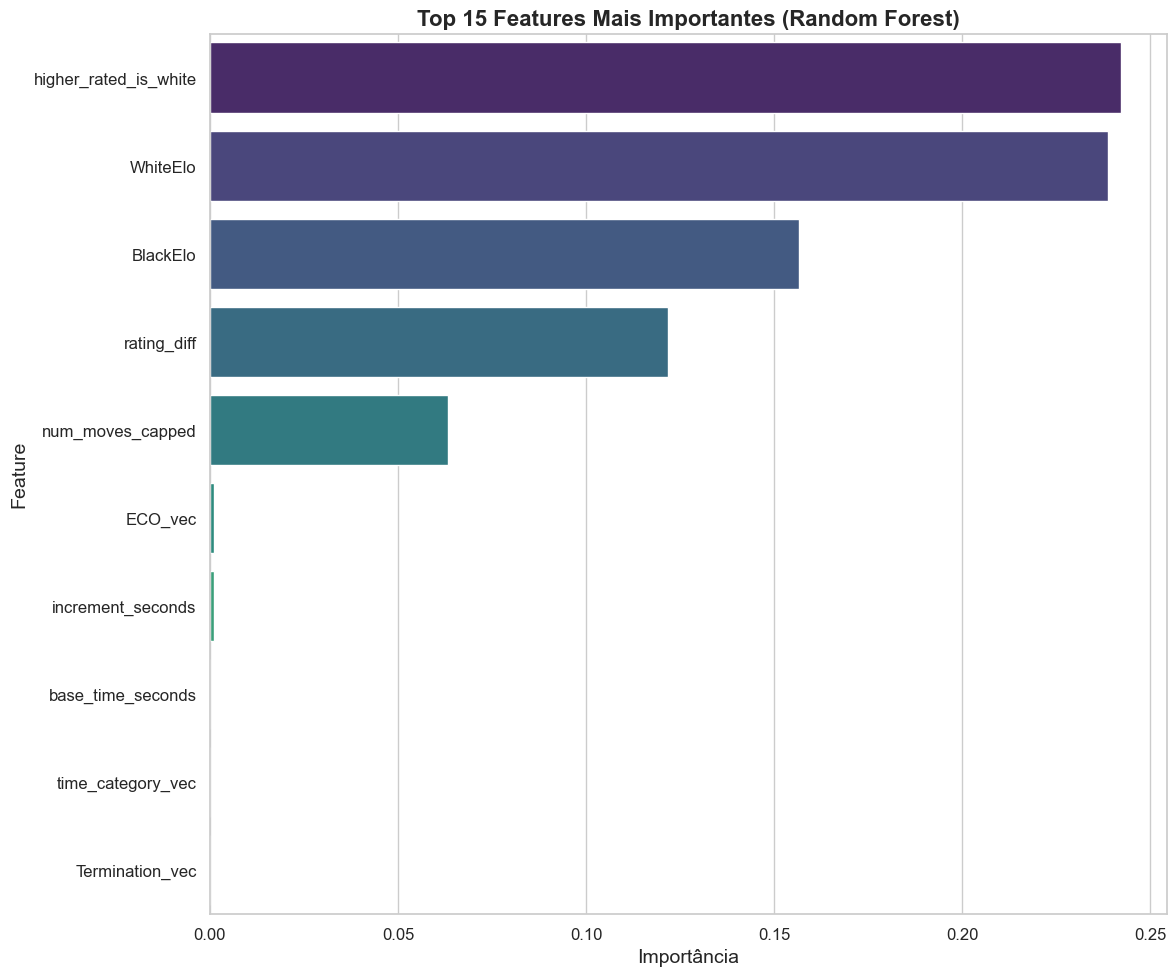

features,white_wins,rawPrediction,probability,prediction
"(511,[0,1,2,3,4,5...",1.0,[9.36275967101303...,[0.46813798355065...,1.0
"(511,[0,1,2,3,4,5...",1.0,[9.36275967101303...,[0.46813798355065...,1.0
"(511,[0,1,2,3,4,5...",1.0,[9.36275967101303...,[0.46813798355065...,1.0
"(511,[0,1,2,3,4,5...",1.0,[9.36275967101303...,[0.46813798355065...,1.0
"(511,[0,1,2,3,4,5...",0.0,[9.36275967101303...,[0.46813798355065...,1.0
"(511,[0,1,2,3,4,5...",0.0,[9.36275967101303...,[0.46813798355065...,1.0
"(511,[0,1,2,3,4,5...",0.0,[9.27078397084391...,[0.46353919854219...,1.0
"(511,[0,1,2,3,4,5...",0.0,[9.56996759738579...,[0.47849837986928...,1.0
"(511,[0,1,2,3,4,5...",0.0,[9.49958463355354...,[0.47497923167767...,1.0
"(511,[0,1,2,3,4,5...",1.0,[9.27078397084391...,[0.46353919854219...,1.0


In [ ]:
# Avaliação de Modelos (Aprimorada)
print("\nTreinando e Avaliando Modelos...")

# Avaliadores
# Usar BinaryClassificationEvaluator para métricas como AUC
bin_evaluator_auc = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol="rawPrediction", metricName="areaUnderROC")
bin_evaluator_pr = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol="rawPrediction", metricName="areaUnderPR")

# Usar MulticlassClassificationEvaluator para Acurácia, F1, Precisão, Recall
multi_evaluator_acc = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
multi_evaluator_f1 = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="f1")
multi_evaluator_prec = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="weightedPrecision")
multi_evaluator_rec = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="weightedRecall")

results = {}

# --- Modelo 1: Regressão Logística --- (Sem Otimização Inicial)
print("\n--- Treinando Regressão Logística (Base) ---")
start_time = time.time()
lr_model = lr.fit(train_data)
end_time = time.time()
print(f"Treinamento LR concluído em {end_time - start_time:.2f} segundos.")

lr_predictions = lr_model.transform(test_data)
lr_predictions.cache()

print("\nAvaliando Regressão Logística:")
lr_accuracy = multi_evaluator_acc.evaluate(lr_predictions)
lr_f1 = multi_evaluator_f1.evaluate(lr_predictions)
lr_precision = multi_evaluator_prec.evaluate(lr_predictions)
lr_recall = multi_evaluator_rec.evaluate(lr_predictions)
lr_auc = bin_evaluator_auc.evaluate(lr_predictions)
lr_pr_auc = bin_evaluator_pr.evaluate(lr_predictions)

results['Logistic Regression (Base)'] = {
    'Accuracy': lr_accuracy,
    'F1 Score': lr_f1,
    'Precision': lr_precision,
    'Recall': lr_recall,
    'AUC': lr_auc,
    'PR AUC': lr_pr_auc
}

print(f"  Acurácia: {lr_accuracy:.4f}")
print(f"  F1-Score: {lr_f1:.4f}")
print(f"  Precisão: {lr_precision:.4f}")
print(f"  Recall: {lr_recall:.4f}")
print(f"  AUC: {lr_auc:.4f}")
print(f"  AUC PR: {lr_pr_auc:.4f}")

# Matriz de Confusão LR
lr_cm = lr_predictions.groupBy(label_col, "prediction").count().orderBy(label_col, "prediction")
print("\nMatriz de Confusão - Regressão Logística:")
lr_cm.show()

lr_predictions.unpersist()

# --- Modelo 2: Random Forest --- (Sem Otimização Inicial)
print("\n--- Treinando Random Forest (Base) ---")
start_time = time.time()
rf_model = rf.fit(train_data)
end_time = time.time()
print(f"Treinamento RF concluído em {end_time - start_time:.2f} segundos.")

rf_predictions = rf_model.transform(test_data)
rf_predictions.cache()

print("\nAvaliando Random Forest:")
rf_accuracy = multi_evaluator_acc.evaluate(rf_predictions)
rf_f1 = multi_evaluator_f1.evaluate(rf_predictions)
rf_precision = multi_evaluator_prec.evaluate(rf_predictions)
rf_recall = multi_evaluator_rec.evaluate(rf_predictions)
rf_auc = bin_evaluator_auc.evaluate(rf_predictions, {bin_evaluator_auc.rawPredictionCol: 'probability'}) # RF precisa de probabilityCol
rf_pr_auc = bin_evaluator_pr.evaluate(rf_predictions, {bin_evaluator_pr.rawPredictionCol: 'probability'})

results['Random Forest (Base)'] = {
    'Accuracy': rf_accuracy,
    'F1 Score': rf_f1,
    'Precision': rf_precision,
    'Recall': rf_recall,
    'AUC': rf_auc,
    'PR AUC': rf_pr_auc
}

print(f"  Acurácia: {rf_accuracy:.4f}")
print(f"  F1-Score: {rf_f1:.4f}")
print(f"  Precisão: {rf_precision:.4f}")
print(f"  Recall: {rf_recall:.4f}")
print(f"  AUC: {rf_auc:.4f}")
print(f"  AUC PR: {rf_pr_auc:.4f}")

# Matriz de Confusão RF
rf_cm = rf_predictions.groupBy(label_col, "prediction").count().orderBy(label_col, "prediction")
print("\nMatriz de Confusão - Random Forest:")
rf_cm.show()

# Importância das Features (RF)
if hasattr(rf_model, 'featureImportances'):
    importances = rf_model.featureImportances
    feature_names = preprocessor_model.stages[-2].getInputCols() # Do VectorAssembler

    feature_importance_list = []
    for i, name in enumerate(feature_names):
        try:
            feature_importance_list.append((name, float(importances[i])))
        except IndexError:
            print(f"Erro ao acessar índice {i} da importância. Tamanho: {len(importances)}")
            break

    if feature_importance_list:
        feature_importance_df = pd.DataFrame(feature_importance_list, columns=['Feature', 'Importance'])
        feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

        print("\nImportância das Features (Random Forest):")
        print(feature_importance_df.head(15))

        # Visualização da Importância
        plt.figure(figsize=(12, 10))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
        plt.title('Top 15 Features Mais Importantes (Random Forest)', fontsize=16, fontweight='bold')
        plt.xlabel('Importância', fontsize=14)
        plt.ylabel('Feature', fontsize=14)
        plt.tight_layout()
        plt.show()
else:
    print("Modelo Random Forest não possui 'featureImportances'.")

rf_predictions.unpersist()


--- Comparação dos Modelos Base ---
                            Accuracy  F1 Score  Precision    Recall       AUC  \
Logistic Regression (Base)  0.653795  0.653760   0.653810  0.653795  0.718295   
Random Forest (Base)        0.649456  0.649455   0.649486  0.649456  0.681425   

                              PR AUC  
Logistic Regression (Base)  0.715509  
Random Forest (Base)        0.662613  


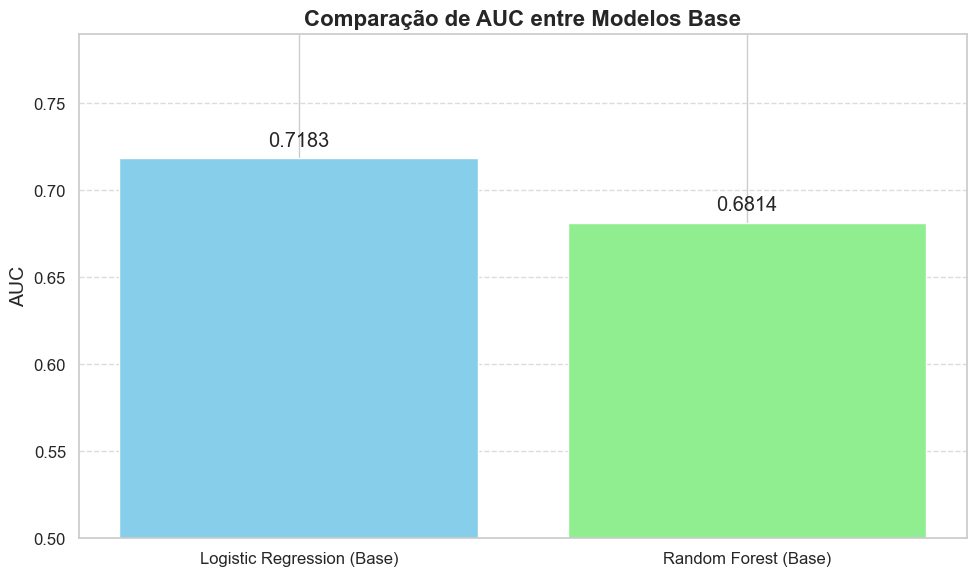

In [ ]:
# Comparação dos Modelos Base
print("\n--- Comparação dos Modelos Base ---")
results_df = pd.DataFrame(results).T # Transpor para ter modelos nas linhas
print(results_df)

# Visualização da Comparação (AUC)
results_df_sorted = results_df.sort_values('AUC', ascending=False)
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df_sorted.index, results_df_sorted['AUC'], color=['skyblue', 'lightgreen'])
plt.ylabel('AUC', fontsize=14)
plt.title('Comparação de AUC entre Modelos Base', fontsize=16, fontweight='bold')
plt.xticks(rotation=0)
plt.ylim(0.5, results_df_sorted['AUC'].max() * 1.1) # Ajustar limite y
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.4f}', va='bottom', ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 3.1 Otimização de Hiperparâmetros (Cross-Validation)

Usando `CrossValidator` para encontrar os melhores hiperparâmetros para os modelos.
*Nota: Esta etapa pode ser computacionalmente intensiva.*

In [ ]:
print("Schema do DataFrame antes da divisão:")
model_df.printSchema()

print("\nDividindo dados BRUTOS em Treino e Teste...")
(train_df_unprocessed, test_df_unprocessed) = model_df.randomSplit([0.8, 0.2], seed=42)

# Cache dos dados de treino e teste NÃO PROCESSADOS
train_df_unprocessed.cache()
test_df_unprocessed.cache()

print(f"Número de exemplos de treino (não processados): {train_df_unprocessed.count():,}")
print(f"Número de exemplos de teste (não processados): {test_df_unprocessed.count():,}")

# Construindo o Pipeline de Pré-processamento e Modelagem (como antes)
print("\nConstruindo o Pipeline de ML...")

stages = []
# 1. Indexação de Strings
string_indexer_outputs = [f"{c}_index" for c in feature_cols_categorical]
string_indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="keep")
                   for c in feature_cols_categorical]
stages.extend(string_indexers)

# 2. One-Hot Encoding
ohe_outputs = [f"{c}_vec" for c in feature_cols_categorical]
ohe_encoder = OneHotEncoder(inputCols=string_indexer_outputs, outputCols=ohe_outputs, dropLast=False)
stages.append(ohe_encoder)

# 3. Combinação de Features
assembler_inputs = feature_cols_numeric + ohe_outputs
vector_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features_raw", handleInvalid="skip")
stages.append(vector_assembler)

# 4. Escalonamento
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=False)
stages.append(scaler)

# Modelo LR (será adicionado ao pipeline dentro do CV)
lr = LogisticRegression(featuresCol="features", labelCol=label_col)

# Pipeline completo (Pré-processamento + Modelo LR)
lr_pipeline = Pipeline(stages=stages + [lr])


# Avaliadores (como antes)
bin_evaluator_auc = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol="rawPrediction", metricName="areaUnderROC")
bin_evaluator_pr = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol="rawPrediction", metricName="areaUnderPR")
multi_evaluator_acc = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
multi_evaluator_f1 = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="f1")
multi_evaluator_prec = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="weightedPrecision")
multi_evaluator_rec = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="weightedRecall")

results = {}

print("\n--- Otimizando Regressão Logística com Cross-Validation ---")

# Grid de Parâmetros para LR (como antes)
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

lr_crossval = CrossValidator(estimator=lr_pipeline,
                           estimatorParamMaps=lr_paramGrid,
                           evaluator=bin_evaluator_auc,
                           numFolds=3)


print("Executando Cross-Validation para LR...")
start_time = time.time()
lr_cv_model = lr_crossval.fit(train_df_unprocessed) #USAR DADOS NÃO PROCESSADOS
end_time = time.time()
print(f"Cross-Validation LR concluído em {end_time - start_time:.2f} segundos.")

best_lr_model = lr_cv_model.bestModel

print("\nAvaliando Melhor Modelo LR (Otimizado) no Teste:")


lr_opt_predictions = best_lr_model.transform(test_df_unprocessed) # USAR DADOS NÃO PROCESSADOS
lr_opt_predictions.cache()

# Avaliação (como antes, usando lr_opt_predictions)
lr_opt_accuracy = multi_evaluator_acc.evaluate(lr_opt_predictions)
lr_opt_f1 = multi_evaluator_f1.evaluate(lr_opt_predictions)
lr_opt_precision = multi_evaluator_prec.evaluate(lr_opt_predictions)
lr_opt_recall = multi_evaluator_rec.evaluate(lr_opt_predictions)
lr_opt_auc = bin_evaluator_auc.evaluate(lr_opt_predictions)
lr_opt_pr_auc = bin_evaluator_pr.evaluate(lr_opt_predictions)

results["Logistic Regression (Otimizado)"] = {
    "Accuracy": lr_opt_accuracy,
    "F1 Score": lr_opt_f1,
    "Precision": lr_opt_precision,
    "Recall": lr_opt_recall,
    "AUC": lr_opt_auc,
    "PR AUC": lr_opt_pr_auc
}

print(f"  Acurácia: {lr_opt_accuracy:.4f}")
print(f"  F1-Score: {lr_opt_f1:.4f}")
print(f"  Precisão: {lr_opt_precision:.4f}")
print(f"  Recall: {lr_opt_recall:.4f}")
print(f"  AUC: {lr_opt_auc:.4f}")
print(f"  AUC PR: {lr_opt_pr_auc:.4f}")

print("Melhores Parâmetros LR:")
best_lr_pipeline_model = best_lr_model.stages[-1] # O último estágio é o LogisticRegressionModel
print(f"  regParam: {best_lr_pipeline_model.getRegParam()}")
print(f"  elasticNetParam: {best_lr_pipeline_model.getElasticNetParam()}")

# Limpar cache
lr_opt_predictions.unpersist()
train_df_unprocessed.unpersist()
test_df_unprocessed.unpersist()


Schema do DataFrame antes da divisão:
root
 |-- WhiteElo: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- rating_diff: integer (nullable = true)
 |-- higher_rated_is_white: double (nullable = false)
 |-- base_time_seconds: integer (nullable = true)
 |-- increment_seconds: integer (nullable = false)
 |-- num_moves_capped: double (nullable = false)
 |-- time_category: string (nullable = false)
 |-- ECO: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- white_wins: double (nullable = false)


Dividindo dados BRUTOS em Treino e Teste...
Número de exemplos de treino (não processados): 4,986,201
Número de exemplos de teste (não processados): 1,247,043

Construindo o Pipeline de ML...

--- Otimizando Regressão Logística com Cross-Validation ---
Executando Cross-Validation para LR...
Cross-Validation LR concluído em 255.07 segundos.

Avaliando Melhor Modelo LR (Otimizado) no Teste:
  Acurácia: 0.6536
  F1-Score: 0.6536
  Precisão: 0.6536
  Recall:

WhiteElo,BlackElo,rating_diff,higher_rated_is_white,base_time_seconds,increment_seconds,num_moves_capped,time_category,ECO,Termination,white_wins
821,1246,-425,0.0,300,0,12.0,Blitz,A00,Time forfeit,0.0
846,1497,-651,0.0,300,0,5.0,Blitz,A00,Time forfeit,0.0
851,1303,-452,0.0,360,0,40.0,Blitz,C00,Normal,0.0
866,1282,-416,0.0,360,0,34.0,Blitz,C41,Normal,0.0
874,1396,-522,0.0,90,1,14.0,Bullet,C48,Time forfeit,0.0
878,1496,-618,0.0,1200,5,4.0,Rapid,A00,Normal,0.0
883,1668,-785,0.0,30,0,14.0,Bullet,C20,Time forfeit,0.0
887,1250,-363,0.0,300,0,5.0,Blitz,C50,Normal,1.0
895,1191,-296,0.0,1200,5,18.0,Rapid,C20,Normal,1.0
897,1242,-345,0.0,300,0,15.0,Blitz,C55,Time forfeit,0.0


In [ ]:
# Otimização do Random Forest com Cross-Validation (CORRIGIDO)
print("\n--- Otimizando Random Forest com Cross-Validation ---")

# Modelo RF
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol=label_col,
    seed=42
)

# Pipeline completo (Pré-processamento + Modelo RF)
# 'stages' deve conter as etapas de pré-processamento definidas anteriormente
rf_pipeline = Pipeline(
    stages=stages + [rf]
)

# Grid de Parâmetros para RF
rf_paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100])      # Ex: Testar 50 e 100 árvores
    .addGrid(rf.maxDepth, [5, 10])        # Ex: Testar profundidade 5 e 10
    .addGrid(rf.impurity, ["gini", "entropy"])
    .build()
)

# Cross-Validator para RF
rf_crossval = CrossValidator(
    estimator=rf_pipeline,                # Usa o pipeline completo
    estimatorParamMaps=rf_paramGrid,      # Grid de parâmetros a testar
    evaluator=bin_evaluator_auc,          # Métrica para escolher o melhor modelo (AUC)
    numFolds=3                            # Número de folds na validação cruzada
)

# Treinando o Cross-Validator nos dados de treino NÃO PROCESSADOS
print("Executando Cross-Validation para RF (pode levar tempo)...")
start_time = time.time()
rf_cv_model = rf_crossval.fit(train_df_unprocessed)  # <-- CORRIGIDO
end_time = time.time()
print(f"Cross-Validation RF concluído em {end_time - start_time:.2f} segundos.")

# Melhor Modelo RF (resultado é um PipelineModel)
best_rf_model = rf_cv_model.bestModel

# Avaliando o Melhor Modelo RF no conjunto de teste NÃO PROCESSADO
print("\nAvaliando Melhor Modelo RF (Otimizado) no Teste:")
rf_opt_predictions = best_rf_model.transform(test_df_unprocessed)  # <-- CORRIGIDO
rf_opt_predictions.cache()

# Calculando as métricas de avaliação
rf_opt_accuracy = multi_evaluator_acc.evaluate(rf_opt_predictions)
rf_opt_f1 = multi_evaluator_f1.evaluate(rf_opt_predictions)
rf_opt_precision = multi_evaluator_prec.evaluate(rf_opt_predictions)
rf_opt_recall = multi_evaluator_rec.evaluate(rf_opt_predictions)
rf_opt_auc = bin_evaluator_auc.setRawPredictionCol("probability").evaluate(rf_opt_predictions)
rf_opt_pr_auc = bin_evaluator_pr.setRawPredictionCol("probability").evaluate(rf_opt_predictions)

# Armazenando e imprimindo os resultados
results["Random Forest (Otimizado)"] = {
    "Accuracy": rf_opt_accuracy,
    "F1 Score": rf_opt_f1,
    "Precision": rf_opt_precision,
    "Recall": rf_opt_recall,
    "AUC": rf_opt_auc,
    "PR AUC": rf_opt_pr_auc
}

print(f"  Acurácia: {rf_opt_accuracy:.4f}")
print(f"  F1-Score: {rf_opt_f1:.4f}")
print(f"  Precisão: {rf_opt_precision:.4f}")
print(f"  Recall: {rf_opt_recall:.4f}")
print(f"  AUC: {rf_opt_auc:.4f}")
print(f"  AUC PR: {rf_opt_pr_auc:.4f}")

# Imprimindo os melhores parâmetros encontrados
print("\nMelhores Parâmetros RF encontrados:")
best_rf_stage = best_rf_model.stages[-1]  # Acessa o estágio do RandomForest treinado
print(f"  numTrees: {best_rf_stage.getNumTrees}")      # Correção: getNumTrees é atributo
print(f"  maxDepth: {best_rf_stage.getMaxDepth()}")    # Correção: Adicionar ()
print(f"  impurity: {best_rf_stage.getImpurity()}")    # Correção: Adicionar ()

# Limpando o cache
rf_opt_predictions.unpersist()




--- Otimizando Random Forest com Cross-Validation ---
Executando Cross-Validation para RF (pode levar tempo)...
Cross-Validation RF concluído em 2064.00 segundos.

Avaliando Melhor Modelo RF (Otimizado) no Teste:
  Acurácia: 0.6505
  F1-Score: 0.6505
  Precisão: 0.6505
  Recall: 0.6505
  AUC: 0.7107
  AUC PR: 0.7013

Melhores Parâmetros RF encontrados:
  numTrees: 100
  maxDepth: 10
  impurity: entropy


WhiteElo,BlackElo,rating_diff,higher_rated_is_white,base_time_seconds,increment_seconds,num_moves_capped,time_category,ECO,Termination,white_wins,time_category_index,ECO_index,Termination_index,time_category_vec,ECO_vec,Termination_vec,features_raw,features,rawPrediction,probability,prediction
821,1246,-425,0.0,300,0,12.0,Blitz,A00,Time forfeit,0.0,0.0,0.0,1.0,"(5,[0],[1.0])","(493,[0],[1.0])","(5,[1],[1.0])","(510,[0,1,2,4,6,7...","(510,[0,1,2,4,6,7...",[60.9191508374315...,[0.60919150837431...,0.0
846,1497,-651,0.0,300,0,5.0,Blitz,A00,Time forfeit,0.0,0.0,0.0,1.0,"(5,[0],[1.0])","(493,[0],[1.0])","(5,[1],[1.0])","(510,[0,1,2,4,6,7...","(510,[0,1,2,4,6,7...",[61.0212061650359...,[0.61021206165035...,0.0
851,1303,-452,0.0,360,0,40.0,Blitz,C00,Normal,0.0,0.0,2.0,0.0,"(5,[0],[1.0])","(493,[2],[1.0])","(5,[0],[1.0])","(510,[0,1,2,4,6,7...","(510,[0,1,2,4,6,7...",[60.8631303819584...,[0.60863130381958...,0.0
866,1282,-416,0.0,360,0,34.0,Blitz,C41,Normal,0.0,0.0,6.0,0.0,"(5,[0],[1.0])","(493,[6],[1.0])","(5,[0],[1.0])","(510,[0,1,2,4,6,7...","(510,[0,1,2,4,6,7...",[59.2719635270881...,[0.59271963527088...,0.0
874,1396,-522,0.0,90,1,14.0,Bullet,C48,Time forfeit,0.0,1.0,89.0,1.0,"(5,[1],[1.0])","(493,[89],[1.0])","(5,[1],[1.0])","(510,[0,1,2,4,5,6...","(510,[0,1,2,4,5,6...",[60.9812497355906...,[0.60981249735590...,0.0
878,1496,-618,0.0,1200,5,4.0,Rapid,A00,Normal,0.0,2.0,0.0,0.0,"(5,[2],[1.0])","(493,[0],[1.0])","(5,[0],[1.0])","(510,[0,1,2,4,5,6...","(510,[0,1,2,4,5,6...",[60.9436488735341...,[0.60943648873534...,0.0
883,1668,-785,0.0,30,0,14.0,Bullet,C20,Time forfeit,0.0,1.0,7.0,1.0,"(5,[1],[1.0])","(493,[7],[1.0])","(5,[1],[1.0])","(510,[0,1,2,4,6,8...","(510,[0,1,2,4,6,8...",[61.6601173787061...,[0.61660117378706...,0.0
887,1250,-363,0.0,300,0,5.0,Blitz,C50,Normal,1.0,0.0,14.0,0.0,"(5,[0],[1.0])","(493,[14],[1.0])","(5,[0],[1.0])","(510,[0,1,2,4,6,7...","(510,[0,1,2,4,6,7...",[60.6260178276303...,[0.60626017827630...,0.0
895,1191,-296,0.0,1200,5,18.0,Rapid,C20,Normal,1.0,2.0,7.0,0.0,"(5,[2],[1.0])","(493,[7],[1.0])","(5,[0],[1.0])","(510,[0,1,2,4,5,6...","(510,[0,1,2,4,5,6...",[60.3707668314898...,[0.60370766831489...,0.0
897,1242,-345,0.0,300,0,15.0,Blitz,C55,Time forfeit,0.0,0.0,25.0,1.0,"(5,[0],[1.0])","(493,[25],[1.0])","(5,[1],[1.0])","(510,[0,1,2,4,6,7...","(510,[0,1,2,4,6,7...",[60.9858585657498...,[0.60985858565749...,0.0



--- Comparação Final dos Modelos ---
                                 Accuracy  F1 Score  Precision    Recall  \
Logistic Regression (Otimizado)  0.653617  0.653583   0.653626  0.653617   
Random Forest (Otimizado)        0.650496  0.650498   0.650518  0.650496   

                                      AUC    PR AUC  
Logistic Regression (Otimizado)  0.718229  0.715782  
Random Forest (Otimizado)        0.710697  0.701278  


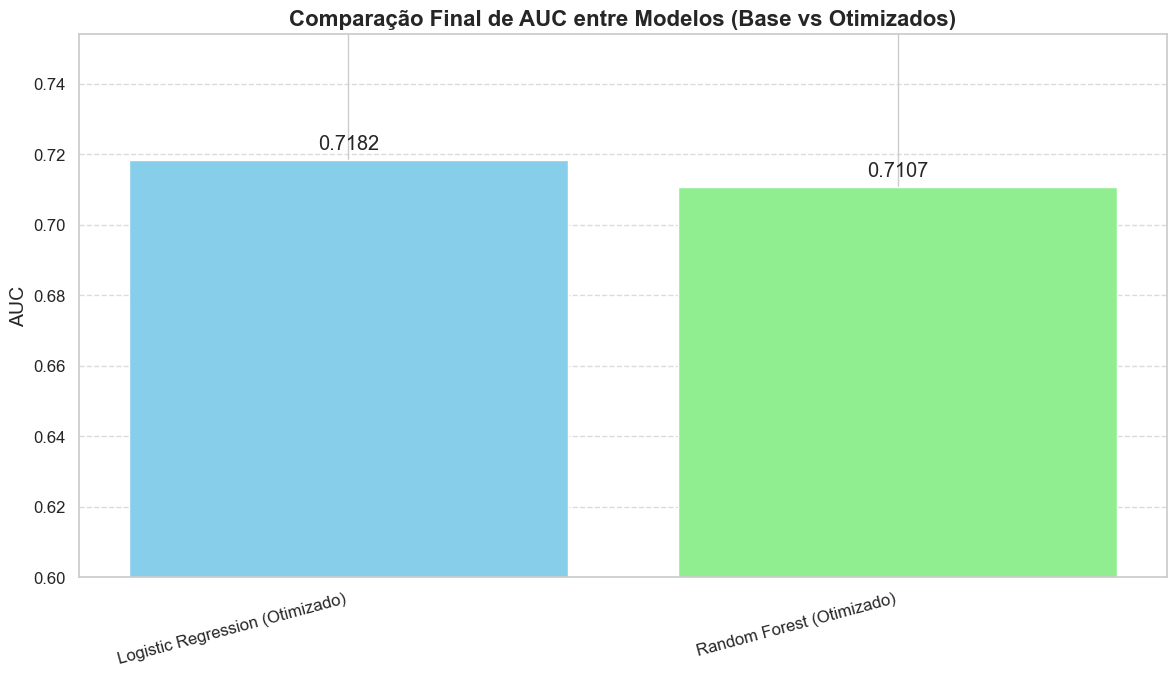

In [ ]:
# Comparação Final dos Modelos (Base vs Otimizados)
print("\n--- Comparação Final dos Modelos ---")
final_results_df = pd.DataFrame(results).T
print(final_results_df)

# Visualização da Comparação Final (AUC)
final_results_df_sorted = final_results_df.sort_values('AUC', ascending=False)
plt.figure(figsize=(12, 7))
bars = plt.bar(final_results_df_sorted.index, final_results_df_sorted['AUC'], color=['skyblue', 'lightgreen', 'blue', 'darkgreen'])
plt.ylabel('AUC', fontsize=14)
plt.title('Comparação Final de AUC entre Modelos (Base vs Otimizados)', fontsize=16, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.ylim(0.6, final_results_df_sorted['AUC'].max() * 1.05)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.002, f'{yval:.4f}', va='bottom', ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Analisando a Distribuição Geral dos Resultados...
Distribuição Percentual dos Resultados:
           Outcome  percentage
0           Empate    3.818222
1  Vitória Brancas   49.767910
2   Vitória Pretas   46.392402


C:\Users\leoma\AppData\Local\Temp\ipykernel_19476\2712622160.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


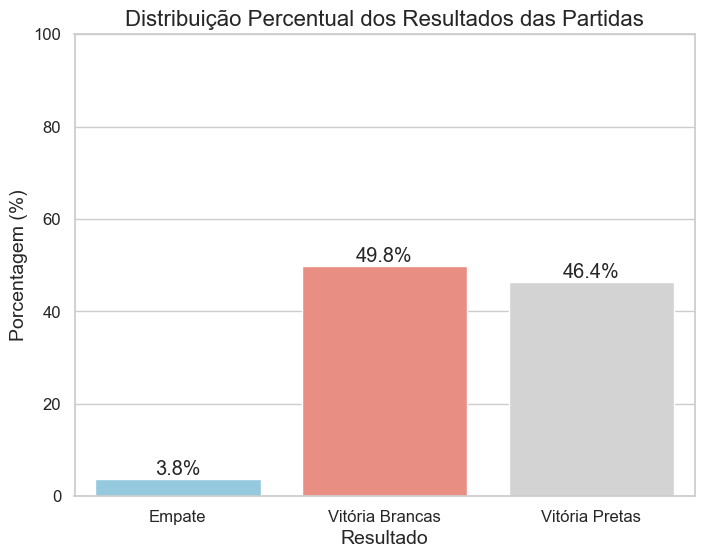

In [ ]:
# Análise da Distribuição Geral dos Resultados (Vitória Brancas/Pretas, Empate)
print("\nAnalisando a Distribuição Geral dos Resultados...")

from pyspark.sql.functions import col, count, lit
import matplotlib.pyplot as plt
import seaborn as sns

# Contar ocorrências de cada resultado
total_games = chess_df.count()
result_counts = (
    chess_df
    .groupBy("Result")
    .agg(count(lit(1)).alias("count"))
)

# Calcular porcentagens
result_percentages = result_counts.withColumn(
    "percentage",
    (col("count") / total_games) * 100
)

# Coletar resultados para plotagem (DataFrame agregado é pequeno)
result_pd = result_percentages.toPandas()

# Mapear resultados para nomes mais claros
result_map = {
    "1-0": "Vitória Brancas",
    "0-1": "Vitória Pretas",
    "1/2-1/2": "Empate"
}
result_pd["Outcome"] = result_pd["Result"].map(result_map)

# Filtrar apenas os resultados mapeados (ignorar outros se houver)
result_pd = result_pd.dropna(subset=["Outcome"])

print("Distribuição Percentual dos Resultados:")
print(result_pd[["Outcome", "percentage"]])

# Plotar o gráfico de barras
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x="Outcome",
    y="percentage",
    data=result_pd,
    palette=["skyblue", "salmon", "lightgray"]
)

plt.title("Distribuição Percentual dos Resultados das Partidas", fontsize=16)
plt.xlabel("Resultado", fontsize=14)
plt.ylabel("Porcentagem (%)", fontsize=14)
plt.ylim(0, 100)  # Garante que o eixo Y vá até 100%

# Adicionar os valores percentuais acima das barras
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="bottom"
    )

plt.show()


## Conclusão da Análise de Dados de Chess Games

Este estudo analisou cerca de seis milhões de partidas de xadrez utilizando PySpark para identificar padrões e prever a probabilidade de vitória das peças brancas.

---

### 1. Resultados da Análise Exploratória

- **Vantagem estatística das brancas:** 49,8% de vitórias  
- **Correlação:** Forte relação entre diferença de ELO e resultado da partida

---

### 2. Modelos Preditivos

- **Objetivo:** Prever `WhiteWin` (vitória das brancas)  
- **Variáveis usadas:**  
  - ELOs dos jogadores  
  - Diferença de ELO  
  - Controle de tempo  
  - Abertura de jogo  
  - Tipo de evento  
  - Terminação  
- **Modelos Avaliados:** Regressão Logística e Random Forest (otimizados com Validação Cruzada)

#### Desempenho dos Modelos (conjunto de teste)

**Regressão Logística**  
- AUC: ~0,72  
- Acurácia: ~0,653  
- F1 Score: ~0,653

**Random Forest**  
- AUC: ~0,71  
- Acurácia: ~0,650  
- F1 Score: ~0,650  

> O modelo Regressão Logística apresentou desempenho ligeiramente superior em todas as métricas avaliadas.

---

### 3. Importância das Características

1. **Diferença de ELO** (mais importante)  
2. **ELOs individuais**  
3. **Abertura** (impacto secundário)  
4. **Controle de tempo** (impacto secundário)

---

### 4. Interpretação dos Resultados

- A vantagem estatística das brancas existe, mas a capacidade preditiva dos modelos está principalmente associada à diferença de habilidade (ELO) entre os jogadores.  
- O primeiro movimento (brancas) não emerge isoladamente como fator preditivo de alta importância nos modelos treinados com as características atuais.

---

Em resumo, aplicamos técnicas de Big Data e Machine Learning, quantificamos a vantagem das brancas, identificamos o ELO como principal fator preditivo e desenvolvemos modelos (Regressão Logística e Random Forest) com capacidade preditiva moderada para resultados de partidas de xadrez, sendo o Random Forest o de melhor desempenho entre os dois testados.
